### A notebook to handle figures for the (revisions of) the yoder et al. 2016 Global/Nepal ETAS paper.

The objective is a one-stop, run this script and get all your data sets and figures, shopping center. some of the scripts, however, are HUGE. global etas will take a solid 10-30 hours on 8 cores, and the production script (with expanded ranges, lower mcs, etc) might be longer. the geospatial_roc script may be similar -- a full day to run though 625 nepal_etas configurations.

accordingly, big jobs are blocked with 'if_really_do_this' booleans. to really run this, soup to nuts, those blocks will need to be removed (set to True).

Recommended resources:
 - At least 4 (virtual) cores (aka, i5, i7 processors)
 - At least 16 GB RAM. Global ETAS tends to pull ~8-10 GB (depends a bit on what else is running); the subsequent ROC script can easily boost the total RAM consumption to ~13 GB. It may be possible to run these scripts in less memory by breaking them up ouside of the notebook environment.
 - Also, consider closing non-essential web browser windows/tabs, as they can pull a fair bit of memory.

In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz

import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mpd
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#
import geopy.distance
from geopy.distance import vincenty
from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep
from eq_params import *
#
from nepal_figs import *
import nepal_figs
import optimizers
#
import random

#
tzutc = pytz.timezone('UTC')
#
emc = {'lat':32.13, 'lon':-115.30, 'event_date':dtm.datetime(2010,4,4,22,40,41, tzinfo=pytz.timezone('UTC'))}
nepal_epi_lon = 84.698
nepal_epi_lat = 28.175
#
# huh?
#nepal_tms = dtm.datetime(2015, 4, 26, 7, 5, 19 ,tzinfo=pytz.timezone('UTC'))
#  April 25, 2015 at 06:11:26 UTC
nepal_tms = dtm.datetime(2015,4,25,6,11,26, tzinfo=pytz.timezone('UTC'))

#
# set up dict objects for different earthquakes. maybe from eq_params.py ?
param_keys = ['lat_center', 'lon_center', 'to_dt', 'mc', 'mc_auto', 'cat_len_plus']
# what exactly do we use these for?
nepal_params = {key:val for key,val in zip(param_keys, [nepal_epi_lat, nepal_epi_lon, 
                                                        nepal_tms,
                                                        3.0, 4.5, 220])}
emc_params =   {key:val for key,val in zip(param_keys, [emc['lat'], emc['lon'],
                                                      emc['event_date'] + dtm.timedelta(days=5), 2.5, 5.5, 220])}

failed while loading urllib and/or urllib. maybe python 3.x?


### some random geopy bits:
  - easy syntax for great-circle or vincenty (more precise, iterative model) geodetic distances
  - forward and reverse geocoding
  

In [3]:
#

newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(geopy.distance.vincenty(newport_ri, cleveland_oh).miles)
print(geopy.distance.great_circle(newport_ri, cleveland_oh).miles)

from geopy.geocoders import Nominatim
geolocator = Nominatim()
#location = geolocator.geocode("175 5th Avenue NYC")
location = geolocator.geocode("509 S Waiola Ave, La Grange IL")
print(location.address)
print(location.point)

538.3904451566326
537.1485284062816
509, South Waiola Avenue, La Grange, Cook County, Illinois, 60525, United States of America
41 48m 16.8175s N, 87 52m 35.5949s W


### ETAS and ROC figures
  - ETAS map
    - include recent (shortly before forecast date) earthquakes
  - ROC analysis
  
  Also include:
    - ETAS forecast catalog $t<t_0$
    - ETAS test catalog $t>t_0$
    - ETAS data.xyz file
    - Image(s)
    - KML
    - ROC table(s)
  
  For now, copy the make_Nepal_figs from nepal_figs.py. we'll move this to the original, or a new, module when we work out the bugs.

In [4]:
#class nepal__ROC_script(object):
#    def __init__(self, fignum=0, mcs = [4., 5., 6., 7.], n_cpu=None):
fignum=0
mcs = [4., 5., 6., 7.]
n_cpu=None

# full, one stop shopping script for nepal ROC analysis.
#
# first, get nepal ETAS objects:
#etas_fc, etas_test = etas_analyzer.nepal_etas_roc()
#
revisions_data = 'data/revisions_outputs'
if not os.path.isdir(revisions_data): os.makedirs(revisions_data)

### Nepal Forecast(s):

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2010-05-08 00:00:00+00:00
fetch and process catalog for dates: [datetime.datetime(2010, 5, 8, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(2010, 5, 8, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)], 'mc': 3.5, 'lons': [79.698, 89.698], 'lats': [23.175, 33.175], 'incat': None}
data handle fetched...
 no file.
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 288], None)
make_etas():
etas_mpp worker xyz_range:  [0, 1250]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catl

/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2010-04-27 00:00:00+00:00
fetch and process catalog for dates: [datetime.datetime(2010, 4, 27, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 4, 26, 0, 0, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(2010, 4, 27, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 4, 26, 0, 0, tzinfo=<UTC>)], 'mc': 3.5, 'lons': [79.698, 89.698], 'lats': [23.175, 33.175], 'incat': None}
data handle fetched...
 no file.
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 225], None)
make_etas():
etas_mpp worker xyz_range:  [0, 3333]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - 

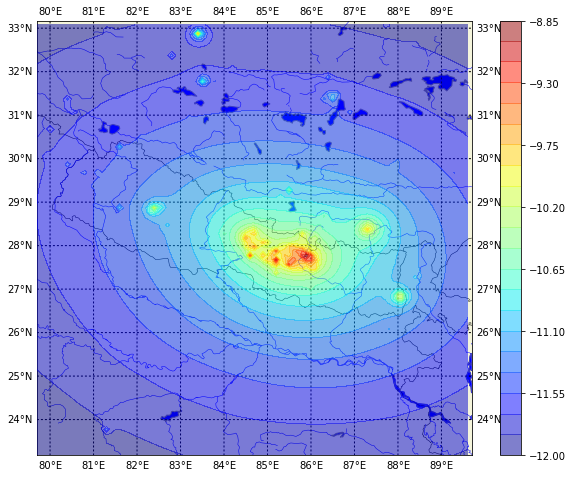

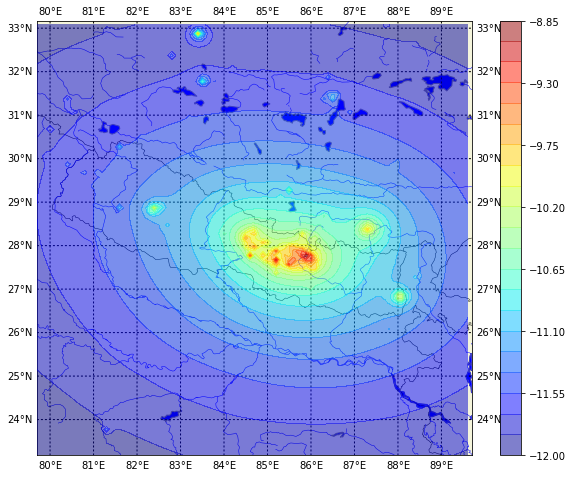

In [5]:
# TODO: code up something to load at least the salient bits from an export file.
#
#
calc_nepal_etas = True
pkl_nepal_etas  = True
#load_nepal_etas_pkl = True
load_nepal_etas_pkl = False
#
pkl_nepal_etas_path='gorkha_data'
nepal_etas_fc_fname   = 'nepal_etas_fc.pkl'
nepal_etas_test_fname = 'nepal_etas_test.pkl'
#
# filenames to load a pickled object:
nepal_etas_fc_fname_in   = nepal_etas_fc_fname
nepal_etas_test_fname_in = nepal_etas_test_fname
#
if calc_nepal_etas:
    nepal_etas_fc = etas_analyzer.get_nepal_etas_fc(n_cpu=2*mpp.cpu_count())
    #plt.savefig(os.path.join(revisions_data, 'nepal_fc_etas_contours.png'))
    #
    # note, nepal_etas_test does not calc. etas, but we'll want etas do to the geospatial bit.
    nepal_etas_test = etas_analyzer.get_nepal_etas_test(n_cpu=2*mpp.cpu_count())
    nepal_etas_test.make_etas()
    #plt.savefig(os.path.join(revisions_data, 'nepal_test_etas_contours.png'))
    if pkl_nepal_etas:
        if not os.path.isdir(pkl_nepal_etas_path):
            os.makedirs(pkl_nepal_etas_path)
        #
        with open(os.path.join(pkl_nepal_etas_path, nepal_etas_fc_fname), 'wb') as fout_fc:
            pickle.dump(nepal_etas_fc, fout_fc)
        with open(os.path.join(pkl_nepal_etas_path, nepal_etas_test_fname), 'wb') as fout_fc:
            pickle.dump(nepal_etas_test, fout_fc)
    #
    # maybe we'll also load up one or more global forecasts as well?
if load_nepal_etas_pkl:
    with open(nepal_etas_fc_fname, 'rb') as fin:
        nepal_etas_fc = pickle.load(fin)
    with open(nepal_etas_test_fname, 'rb') as fin:
        nepal_etas_test = pickle.load(fin)

if True:
    fg = plt.figure(1, figsize=(10,8))
    plt.clf()
    lons_map = None
    lats_map = None
    #lons_map = [84., 87.]
    #lats_map = [27., 29.]
    cm_fc = nepal_etas_fc.make_etas_contour_map(fignum=1, fig_size=(10,8), n_contours=25,
                                                lons_map=lons_map,lats_map=lats_map)
    #cm_fc.scatter(*zip(*[[rw['lon'], rw['lat']] for rw in nepal_etas_fc.catalog if rw['mag']>5.]), marker='.',latlon=True )
    # ... not the way to do this...
    #ax=plt.gca()
    #ax.set_xlim([83.,88.])
    #ax.set_ylim([27., 29.5])
    fg.savefig(os.path.join(revisions_data, 'nepal_fc_etas_contours.png'))
    #
    # # get an 'initial' forecast:
    neapl_etas_initial = etas_analyzer.get_nepal_etas_fc(n_procs=2*mpp.cpu_count(), cat_len=5.*365., p_cat=1.1,
                                                         q_cat=1.5, t_0 = dtm.datetime(1990,1,1, tzinfo=tz_utc),
                                                         t_now=dtm.datetime(2015,4,26, tzinfo=tzutc))
    fg = plt.figure(2,figsize=(10,8))
    plt.clf()
    lons_map = None
    lats_map = None
    #lons_map = [84., 87.]
    #lats_map = [27., 29.]
    # note: we'll make a zoomed version of this and save it down-stream a bit.
    cm_fc = nepal_etas_fc.make_etas_contour_map(fignum=2, fig_size=(10,8), n_contours=25,
                                                    lons_map=lons_map,lats_map=lats_map)

/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


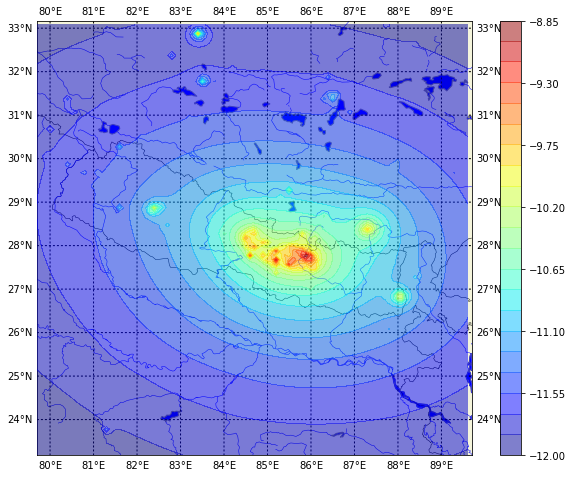

In [6]:
fg = plt.figure(1, figsize=(10,8))
plt.clf()
lons_map = None
lats_map = None
#lons_map = [84., 87.]
#lats_map = [27., 29.]
cm_fc = nepal_etas_fc.make_etas_contour_map(fignum=1, fig_size=(10,8), n_contours=25,
                                            lons_map=lons_map,lats_map=lats_map, map_cmap='jet')
#cm_fc.scatter(*zip(*[[rw['lon'], rw['lat']] for rw in nepal_etas_fc.catalog if rw['mag']>5.]), marker='.',latlon=True )
# ... not the way to do this...
#ax=plt.gca()
#ax.set_xlim([83.,88.])
#ax.set_ylim([27., 29.5])
fg.savefig(os.path.join(revisions_data, 'nepal_fc_etas_contours.png'))

#### Gorkha, Nepal forecast map, up close and with the post-mainshock, pre 12 May, aftershocks plotted (for doubters)

In [7]:
print(nepal_etas_fc.catalog[0]['event_date'], nepal_tms, nepal_etas_fc.catalog[-1]['event_date'])
print(nepal_etas_fc.catalog.dtype.names)
#plt.figure()
#plt.plot(nepal_etas_fc.catalog['event_date'], nepal_etas_fc.catalog['mag'])

2010-06-02T08:05:22.880000 2015-04-25 06:11:26+00:00 2015-05-06T21:56:28.670000
('event_date', 'lat', 'lon', 'mag', 'depth', 'event_date_float', 'L_r', 'r_0', 'chi', 'dt_r', 't_0', 'tau', 'dmstar', 'p', 'q', 'e_vals', 'e_vecs', 'N_eig_cat')


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3

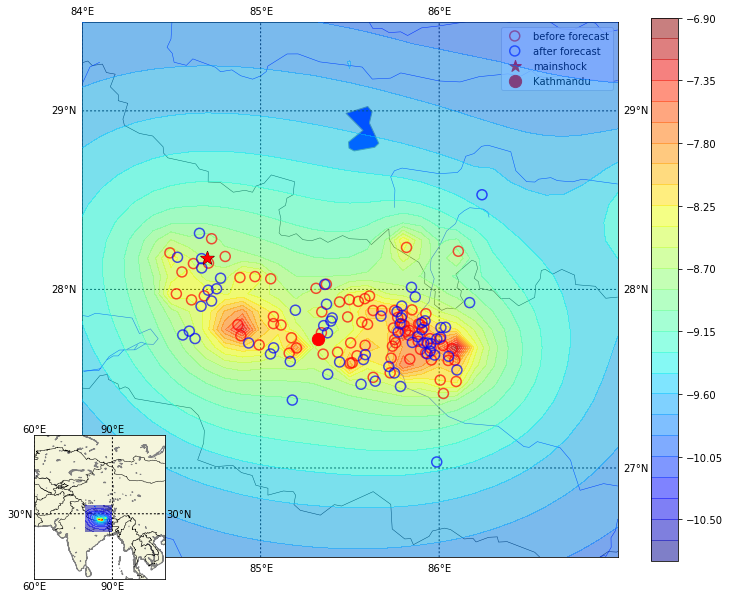

In [8]:
fg = plt.figure(1, figsize=(12,10))
plt.clf()
#lons_map = None
#lats_map = None
lons_map = [84., 87.]
lats_map = [26.5, 29.5]
fnum=1
fg=plt.figure(fnum)
# use initial forecast:
# # # get an 'initial' forecast:
#cm_fc = nepal_etas_fc.make_etas_contour_map(fignum=1, fig_size=(10,8), n_contours=25, lons_map=lons_map,lats_map=lats_map)
cm_fc = neapl_etas_initial.make_etas_contour_map(fignum=fnum, fig_size=(10,8), n_contours=25, lons_map=lons_map,
                                                 lats_map=lats_map)
ax=plt.gca()
#
# two catalogs:
# sub_cat1: events included in the forecast; after mainshock, but before fc_date
# sub_cat2: events after the forecast but before the large aftershocks.
dt_split = dtm.datetime(2015,4,26,tzinfo=pytz.timezone('UTC'))
sub_cat1 = [[rw['lon'], rw['lat']] for rw in nepal_etas_fc.catalog 
                     if (rw['mag']>3. and numpy.datetime64(rw['event_date'])>=numpy.datetime64(nepal_tms)
                   and numpy.datetime64(rw['event_date'])<numpy.datetime64(dt_split))]
sub_cat2 = [[rw['lon'], rw['lat']] for rw in nepal_etas_fc.catalog 
                     if (rw['mag']>3. and numpy.datetime64(rw['event_date'])>=numpy.datetime64(dt_split)
                   and numpy.datetime64(rw['event_date'])<numpy.datetime64(dtm.datetime(2015,5,12,tzinfo=pytz.timezone('UTC'))))]

# note, with "scatter()", we should be able to easily size the elements by magnitude, color them by time, etc. if we want.
cm_fc.scatter(*zip(*sub_cat1),
              marker='o', edgecolors='r', facecolors='none', linewidths=1.5,
              s=100, alpha=.7, latlon=True, zorder=10, label='before forecast' )
cm_fc.scatter(*zip(*sub_cat2),
              marker='o', edgecolors='b', facecolors='none', linewidths=1.5,
              s=100, alpha=.7, latlon=True, zorder=10, label='after forecast')

cm_fc.scatter(*cm_fc(nepal_epi_lon, nepal_epi_lat), marker='*', s=150, color='r', 
              latlon=False, zorder=12, label='mainshock')
cm_fc.scatter(*cm_fc(nepal_epi_lon, nepal_epi_lat), marker='*', s=195, color='k', latlon=False, zorder=11)
#
# and kathmandu:
# 27.7172° N, 85.3240° E
cm_fc.scatter(*cm_fc(85.32, 27.72), marker='o', s=150, color='r', 
              latlon=False, zorder=12, label='Kathmandu')

# ... not the way to do this...
#ax=plt.gca()
#ax.set_xlim([83.,88.])
#ax.set_ylim([27., 29.5])

#ax.legend(loc=0, numpoints=1)
cm_fc.ax.legend(loc=0, numpoints=1)
#cm_fc.legend(loc=0, numpoints=1)

ax_inset = fg.add_axes([.01, .1, .27, .2])
cm_fc = neapl_etas_initial.make_etas_contour_map(ax=ax_inset, fig_size=(10,8), n_contours=25, lons_map=(60,110),
                                                 lats_map=(5,60), lon_interval=30, lat_interval=30, do_colorbar=False,
                                                do_states=False, do_rivers=False, lake_color=None)


#fg.savefig(os.path.join(revisions_data, 'nepal_fc_etas_contours_closeup_with_eqs.png'))

fg.savefig(os.path.join(revisions_data, 'nepal_fc_initial_etas_contours_closeup_with_eqs.png'))

In [9]:
print('revs: ', revisions_data)

revs:  data/revisions_outputs


/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


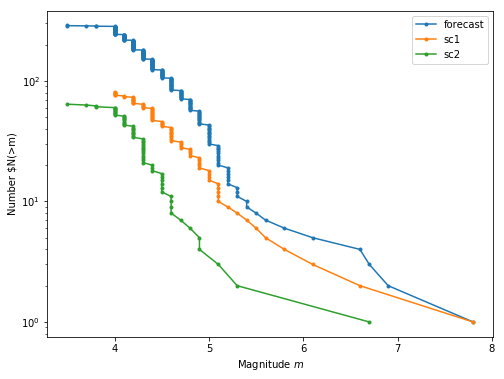

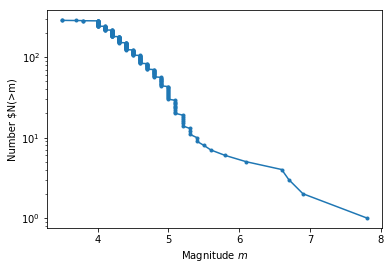

In [10]:
### GR dists of before and after catalogs

sc1 = [[rw['lon'], rw['lat'], rw['mag']] for rw in nepal_etas_fc.catalog 
                     if (rw['mag']>3. and numpy.datetime64(rw['event_date'])>=numpy.datetime64(nepal_tms)
                   and numpy.datetime64(rw['event_date'])<numpy.datetime64(dt_split))]
sc2 = [[rw['lon'], rw['lat'], rw['mag']] for rw in nepal_etas_fc.catalog 
                     if (rw['mag']>3. and numpy.datetime64(rw['event_date'])>=numpy.datetime64(dt_split)
                   and numpy.datetime64(rw['event_date'])<numpy.datetime64(dtm.datetime(2015,5,12,tzinfo=pytz.timezone('UTC'))))]


plt.figure(figsize=(8,6))
plt.clf()
ax=plt.gca()
ax.set_yscale('log')
ax.plot(sorted(nepal_etas_fc.catalog['mag']), len(nepal_etas_fc.catalog) - numpy.arange(len(nepal_etas_fc.catalog)),
        '.-', label='forecast')
ax.plot(sorted([m for x,y,m in sc1]), len(sc1)-numpy.arange(len(sc1)), '.-', label='sc1')
ax.plot(sorted([m for x,y,m in sc2]), len(sc2)-numpy.arange(len(sc2)), '.-', label='sc2')
ax.set_xlabel('Magnitude $m$')
ax.set_ylabel('Number $N(>m)')
ax.legend(loc=0)

plt.figure()
ax = plt.gca()
N = len(nepal_etas_fc.catalog)
ax.plot(sorted(nepal_etas_fc.catalog['mag']), N + 1 - numpy.arange(1, len(nepal_etas_fc.catalog)+1), '.-')
ax.set_yscale('log')
ax.set_xlabel('Magnitude $m$')
ax.set_ylabel('Number $N(>m)')


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


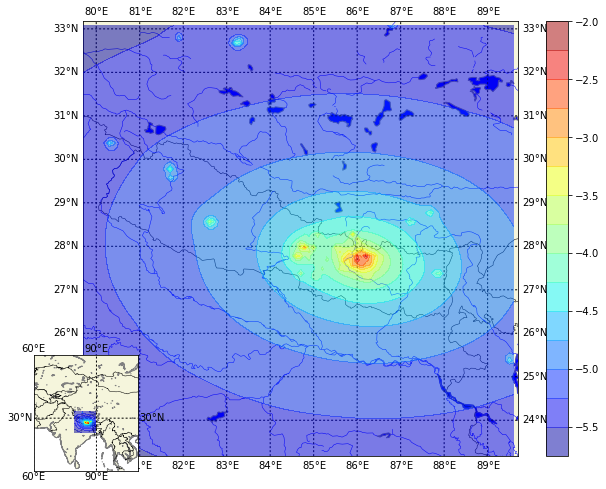

In [11]:
# Nepal "test" catalog: events following the forecast (7 May + 120 days.)
#
fg=plt.figure(2, figsize=(10,8))
plt.clf()
cm_test = nepal_etas_test.make_etas_contour_map(fignum=2, fig_size=(10,8))
#
# draw an inset to show location:
ax_inset = fg.add_axes([.01, .1, .27, .2])
cm_fc = neapl_etas_initial.make_etas_contour_map(ax=ax_inset, fig_size=(10,8), n_contours=25,
                                                 lons_map=(60,110), lats_map=(5,60), lon_interval=30,
                                                 lat_interval=30, do_colorbar=False,
                                                do_states=False, do_rivers=False, lake_color=None)
ax.set_title('Gorkha Test ETAS (7 May + 120 days)\n')
#
fg.savefig(os.path.join(revisions_data, 'nepal_test_etas_contours.png'))

In [12]:
print(min(nepal_etas_test.catalog['event_date']))
print(max(nepal_etas_test.catalog['event_date']))
#
print('max/min fc: ', min(nepal_etas_fc.catalog['event_date']), max(nepal_etas_fc.catalog['event_date']))

2015-05-08T00:32:33.960000
2015-09-01T23:06:40.640000
max/min fc:  2010-06-02T08:05:22.880000 2015-05-06T21:56:28.670000


In [13]:
#etas_test.catalog.dtype

#### ROC figures for Nepal:

ROC for mc=4.0
len(xym_ev):  142
ROC for mc=5.0
len(xym_ev):  12
ROC for mc=6.0
len(xym_ev):  2
ROC for mc=7.0
len(xym_ev):  1


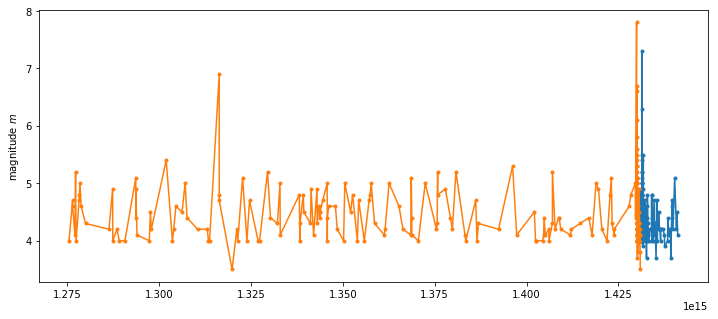

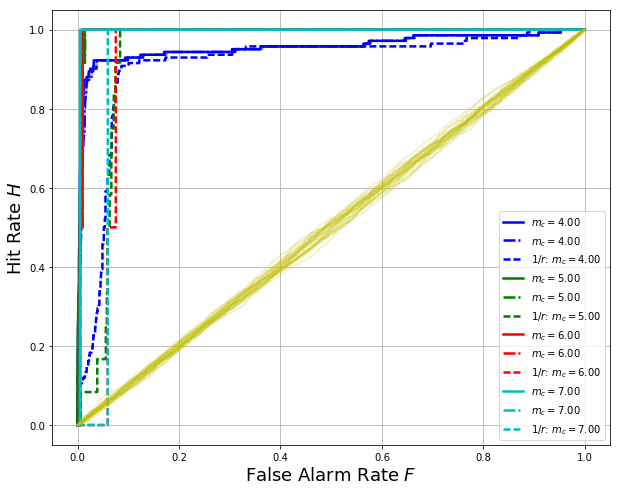

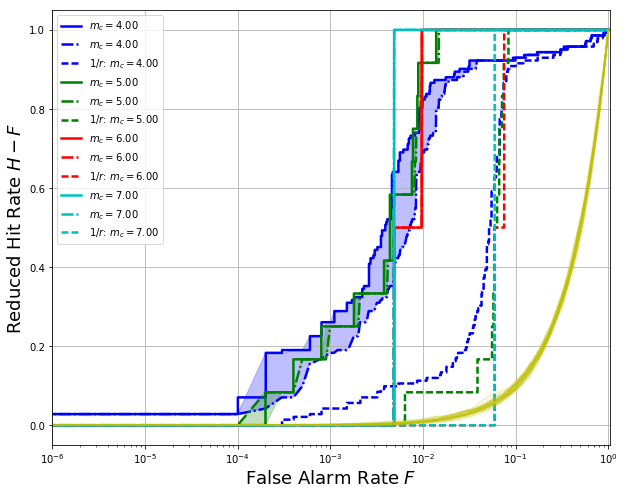

In [89]:
# designate ETAS class instances:
#
etas_test = nepal_etas_test
test_catalog = etas_test.catalog
etas_fc = nepal_etas_fc
#
# do a quick time-series plot from each catalog (just to be sure)
fg=plt.figure(figsize=(12,5))
ax1 = plt.subplot('111')
#ax2 = plt.subplot('212')
t_0_roc = mpd.date2num(etas_fc.catalog['event_date'][-1].astype(dtm.datetime))
ax1.plot(etas_test.catalog['event_date'], etas_test.catalog['mag'], marker='.', ls='-', label='test')
ax1.plot(etas_fc.catalog['event_date'],   etas_fc.catalog['mag'], marker='.', ls='-', label='forecast')
#ax1.set_ylabel('test cat.')
#ax2.set_ylabel('forecast cat.')
ax1.set_ylabel('magnitude $m$')
#

x0 = nepal_epi_lon
y0 = nepal_epi_lat
null_dist_expon = 1.5     # exponent for null model, aka aftershocks fall off like 1/r**null_dist_expon
#
mag=7.8
L_r = .5*10**(.5*mag - 1.76)
xyz = etas_fc.ETAS_array
# make a null mode with z ~ 1/r. we'll probably need a contour figure of this.
xyz_null = [[x,y,((L_r + geopy.distance.great_circle((y,x), (y0,x0)).km)**(-null_dist_expon))] for x,y,z in xyz]
xyz_null_1 = [[x,y,((L_r + geopy.distance.great_circle((y,x), (y0,x0)).km)**(-1.))] for x,y,z in xyz]
#xym_events = list(zip(test_catalog['lon'], test_catalog['lat'], test_catalog['mag']))
xym_events = numpy.array([test_catalog['lon'], test_catalog['lat'], test_catalog['mag']]).T
#
# now, replace all of this m"get x,y and ROC" stuff with the optimizers.roc_tools equivalents.
#roc_xyz_handler = optimizers.ROC_xyz_handler(xyz, list(zip(test_catalog['lon'], test_catalog['lat'], test_catalog['mag'])),
#                                            z_event_min=None)
#
#ROC_handler = ROC_xyz_handler(xyz, xym_events, z_event_min=None)
#
#fg1=plt.figure(fignum, figsize=(10,8))
fg1=plt.figure(figsize=(10,8))
plt.clf()
ax1=plt.gca()
ax1.set_xscale('linear')
#
#fg2=plt.figure(fignum+1, figsize=(10,8))
fg2=plt.figure(figsize=(10,8))
plt.clf()
ax2=plt.gca()
ax2.set_xscale('log')

FHs = []        # we'll use mc as a key, FH as a val: {mc:[FH]...}
for j,mc in enumerate(mcs):
    clr = colors_[j%len(colors_)]
    print('ROC for mc={}'.format(mc))
    #
    # there's a faster way to do this...
    # TODO: clarify this. z should be etas z values; m should be event magnitude. confirm that we are correctly
    #  filtering mc and rename arrays to xyz_stuff, xym_stuff.
    xym_ev = [[x,y,m] for x,y,m in xym_events if m>=mc]
    print("len(xym_ev): ", len(xym_ev))
    ROC_real = optimizers.roc_tools.ROC_xyz_handler(xyz,      xym_events, z_event_min=mc)
    ROC_null = optimizers.roc_tools.ROC_xyz_handler(xyz_null, xym_events, z_event_min=mc)
    #ROC_null_1 = optimizers.roc_tools.ROC_xyz_handler(xyz_null_1, xym_events, z_event_min=mc)
    #
    #events = [z for x,y,z in ROC_handler if z>=mc]
    # calc_roc(Z_fc=self.z_fc, Z_ev=self.z_events
    FH      = ROC_real.calc_roc()
    FH_molc = ROC_real.calc_molchan()
    FH_null = ROC_null.calc_roc()
    FHs += [[mc, {'ROC':FH, 'molc':FH, 'ROC_null':FH_null}]]
    #
    #print('FH_molc: ', FH_molc[-5:])
    #
    # set up an interpolation object so we can do a fill_between() the ROC and Molchan
    f_interp_roc = interpolate.interp1d(*zip(*(list(FH) + [[1.,1.]])))
    f_interp_mol = interpolate.interp1d(*zip(*(list(FH_molc) + [[1.,1.]])))
    x_interp = numpy.linspace(0., 1.,10000)
    #
    y_roc = f_interp_roc(x_interp)
    y_mol = f_interp_mol(x_interp)
    ax1.fill_between(x_interp, y_roc, y_mol, color=clr, alpha=.25)
    
    #x_interp_log = numpy.array([10**x for x in numpy.linspace(min(numpy.log([x for x,y in FH])), 
    #                                                          max(numpy.log([x for x,y in FH])),1000)])
    #f_interp_roc_log=interpolate.interp1d(numpy.log10([x for x,y in FH]), [y for x,y in FH])
    #f_interp_mol_log=interpolate.interp1d(numpy.log10([x for x,y in FH]), [y for x,y in FH_molc])
    ax2.fill_between([1e-6] + list(x_interp), [0.] + list(y_roc), [0.] + list(y_mol), color=clr, alpha=.25)    
    #
    # plot ETAS FH and 'null' (1/r) FH on ax1 (linear)
    ax1.plot(*zip(*FH), ls='-', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    ax1.plot(*zip(*FH_molc), ls='-.', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    ax1.plot(*zip(*FH_null), ls='--', color=clr, marker='', lw=2.5, label='$1/r$: $m_c=%.2f$' % mc)
    #
    # plot ETAS and null (1/r) FH on ax2 (log)
    #ax2.plot(*zip(*[[f,h-f] for f,h in FH]), ls='-', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    #ax2.plot(*zip(*[[f,h-f] for f,h in FH_null]), ls='--', color=clr, marker='', lw=2.5, label='$1/r$: $m_c=%.2f$' % mc)
    ax2.plot(*zip(*FH), ls='-', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    ax2.plot(*zip(*FH_molc), ls='-.', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    #ax2.fill_between([x for x,y in FH], [y for x,y in FH], [y for x,y in FH_molc], color=clr, alpha=.25)
    ax2.plot(*zip(*FH_null), ls='--', color=clr, marker='', lw=2.5, label='$1/r$: $m_c=%.2f$' % mc)
    #
    #
    # now, some random catalogs:

#plt.figure()
#z_min = min([z for x,y,z in xyz])
#z_max = max([z for x,y,z in xyz])
z_len = len(xyz)
for j in range(25):
    # we probably want a better model for this, but if it works, maybe we keep it.
    R = random.Random()
    #xyz_r = [[x,y,xyz[int(z_len*R.random())][2]] for x,y,z in xyz]
    #ROC_rand = optimizers.roc_tools.ROC_xyz_handler(xyz_r, xym_events, z_event_min=mc)
    #
    fh = optimizers.roc_tools.calc_roc([z for x,y,z in xyz], sorted([z for x,y,z in xyz], key=lambda x: R.random())[0:int(.2*z_len)])
    #
    #this_etas = etas_analyzer.Toy_etas_random(etas_in=etas_fc)
    #FH = etas_analyzer.roc_normal(this_etas, fignum=None)
    ax1.plot(*zip(*fh), marker='', ls='-', alpha=.2, color='y')
    ax2.plot(*zip(*[[f,h] for f,h in fh]), marker='', ls='-', alpha=.2, color='y')
#
#ax1.plot(range(2), range(2), ls='--', color='m', lw=3., alpha=.75, zorder=2)
ax1.plot(*zip(*[[x,x] for x in numpy.arange(0.,1.,1000)]), marker='', ls='--', color='m', lw=2.)
ax2.plot(*zip(*[[x,x] for x in numpy.arange(0.,1.,1000)]), marker='', ls='--', color='m', lw=2.)
#
ax1.set_ylim(-.05, 1.05)
ax1.set_xlim((-.05, 1.05))
ax1.grid()
ax1.legend(loc=0, numpoints=1)
ax1.set_ylabel('Hit Rate $H$', size=18)
ax1.set_xlabel('False Alarm Rate $F$', size=18)
#
ax2.set_ylim(-.05, 1.05)
ax2.set_xlim((-.05, 1.05))
ax2.grid()
ax2.legend(loc=0, numpoints=1)
ax2.set_ylabel('Reduced Hit Rate $H-F$', size=18)
ax2.set_xlabel('False Alarm Rate $F$', size=18)
#self.__dict__.update(locals())
#

#################################################
#################################################
with open(os.path.join(revisions_data, 'nepal_xyz_etas_fc.xyz'), 'w') as f:
    f.write('#x\t\ty\tz\n')
    for rw in xyz:
        f.write('{}\n'.format('\t'.join([str(x) for x in rw])))
#
with open(os.path.join(revisions_data, 'nepal_xyz_etas_fc_nul_exp_135.xyz'), 'w') as f:
    f.write('#x\t\ty\tz\n')
    for rw in xyz:
        f.write('{}\n'.format('\t'.join([str(x) for x in rw])))
#

with open(os.path.join(revisions_data, 'nepal_test_catalog.cat'), 'w') as f:
    etas_test.catalog.tofile(f, sep='\t')
with open(os.path.join(revisions_data, 'nepal_fc_catalog.cat'), 'w') as f:    
    nepal_etas_fc.catalog.tofile(f, sep='\t')

fg1.savefig(os.path.join(revisions_data, 'nepal_roc_lin.png'))
fg2.savefig(os.path.join(revisions_data, 'nepal_roc_log.png'))


#A = nepal__ROC_script()

In [95]:
#
for mc, rocs in FHs:
    #print('*** ', mc, rocs.keys())
    for roc, fh in rocs.items():
        skl = numpy.sum([.5*( (h1+h2) - (f1 + f2))*(f1-f2) for (f1, h1), (f2, h2) in zip(fh[1:], fh[:-1])])
        print('mc: {:.3f}, roc: {}, skill: {:.5f}'.format(mc,roc, skl))
#
print(f_interp_mol.x[-5:])
print(f_interp_roc.x[-5:])

mc: 4.000, roc: ROC, skill: 0.45768
mc: 4.000, roc: molc, skill: 0.45768
mc: 4.000, roc: ROC_null, skill: 0.41247
mc: 5.000, roc: ROC, skill: 0.49477
mc: 5.000, roc: molc, skill: 0.49477
mc: 5.000, roc: ROC_null, skill: 0.44137
mc: 6.000, roc: ROC, skill: 0.49270
mc: 6.000, roc: molc, skill: 0.49270
mc: 6.000, roc: ROC_null, skill: 0.43254
mc: 7.000, roc: ROC, skill: 0.49510
mc: 7.000, roc: molc, skill: 0.49510
mc: 7.000, roc: ROC_null, skill: 0.44049
[ 0.9996  0.9997  0.9998  0.9999  1.    ]
[ 0.99969997  0.99979998  0.99989999  1.          1.        ]


In [16]:
# Now, let's write stuff to file:
plt.savefig(os.path.join(revisions_data, 'nepal_roc_figure.png'))


In [17]:
# import global_etas_auto

# aa=global_etas_auto.auto_etas()

# #print(aa)

# #plt.figure(0,figsize=(10,8))
# #ax=plt.gca()
# aa.make_etas_contour_map(fig_size=(10,8), n_contours=25 )
# date_str = str(dtm.datetimen.now())
# plt.title('ETAS, Pacific Islands, {%s}'.format(date_str))
# #
# plt.savefig('data/pacific/pacific_20160729_{}.png'.format(date_str))
# aa.export_xyz('data/pacific/pacific_20160729_{}.xyz'.format(date_str))
# aa.export_kml('data/pacific/pacific_20160729_{}.kml'.format(date_str))

# # ... and eventually write this into globalETAS()
# with open('data/pacific/pacific_cat_20160729_{}.cat'.format(date_str)), 'w') as f:
#     aa.catalog.tofile(f, '\t')

### Global ETAS and ROC
- see nepal_figs.py.global_roc_from_optimizer()


In [18]:
figs_data_path = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs'
xyz_output = os.path.join(figs_data_path, 'global_etas.xyz')
#

In [ ]:
# TODO: this needs to be cleaned up. we've tried to accomodate the super data and compute intensive process
# by allowing some pre-calc options, but now it's just complicated... so consolidate.
# 1) get ETAS (either calc or load; there needs to be a to_date in there somewhere; maybe load a picked
#    object.
# 2) get ROC from roc = optimizers.roc_tools.ROC_xyz_handler(xyz,      xym_events, z_event_min=mc)
#    (see nepal_roc above)
#
# we need to re-code global_etas() to use a Pool() instead of manual process handling. in the mean time, just give it
# more processes than it has processors (then, the small jobs will finish up early, and the multiple-thread overhead
# should be relatively small). the idea is to have all processors running flat out, all the time... and not run out
# of memory.
# TODO: test pickle.load()s
global_roc_etas_etas_fname = 'global_roc_etas.pkl'
global_roc_etas_roc_fame   = 'global_roc_FH.json'
do_global = False
#do_global = True
load_global = True
#
if load_global:
    do_global = False
    #with open()
    #glob_etas_roc = 
    # TODO: this is an organizational mess. separate the ROC and ETAS? load both from pickle?
    with open(global_roc_etas_etas_fname, 'rb') as fin:
        glob_etas_roc = {'etas': pickle.load(fin)}
    with open(global_roc_etas_roc_fname, 'rb') as fin:     
        glob_etas_roc['roc'] = pickle.load(fin)
    #
    

t_roc_global = dtm.datetime(2016,4,12, 12,52,59, tzinfo=pytz.timezone('UTC'))
if do_global:
    n_cpu = mpp.cpu_count()*3
    #
    # note: the default behavior for this is to give a forcast date of now-fc_len, and so a forecast validation up to today.
    #
    # TODO: this needs to be un-packaged i think. we should get an ETAS, then an ROC.
    #t_roc_global = dtm.datetime(2015,10,19, tzinfo=pytz.timezone('UTC'))
    glob_etas_roc =  global_etas_and_roc(fc_len=120, fout_xyz=xyz_output, fignum=0, m_cs=[4.0, 5.0, 6.0, 6.5], 
                                         t_now=t_roc_global, n_cpu=n_cpu)
    #

    with open(os.path.join(figs_data_path, 'global_roc_FH.json'), 'w') as f:
        json.dump(glob_etas_roc['roc'],f)
    #
    # TODO: the problem with this, for the global ETAS, is that it uese up all the memory...
    #    BUT, it really is just a big-memory problem, so as long as there is sufficient swap space,
    #    it is still viable (takes a while to write to disk, but it's not a total run-away process.)
    #with open(os.path.join(figs_data_path, 'global_roc_etas.pkl'), 'wb') as fout:
    #    pickle.dump(glob_etas_roc['etas'], fout)
    ##print(glob_etas_roc.keys())    

In [20]:
#roc_glob = global_roc_from_optimizer(fc_xyz=etas.ETAS_array, fignum=fignum+1, mcs=6.0,
#fc_len=fc_len, ls=roc_ls, marker=roc_marker, lw=roc_lw)
#
# for this script, we might actually load the headers and body data, so we can re-use the body data
# when we repeadedly run ROC (loading from disk is slow).
# in any case, the open-file bit here is to (nominally, eventually) load header data.
#
# print header data from global eatas output:
# (and if we need to, we can extract the prams from here.)
with open(xyz_output,'r') as f:
    for rw in f:
        if rw[0]=='#':
            print(rw)
        else:
            #
            # and assume 1) it's a long file, 2) all the comments are at the front.
            break
        #
    #
#
   

# do roc starting just after end of etas (be careful trying to make this more/less fair;
#see the global_roc_from_optimizer code.)
#
print('begin roc_glob...')
# should be returning like [[mc, [FH]], [mc, [FH]], ]   # where [FH] implies an array return like [[f,h], [f,h], ... ]
roc_glob = global_roc_from_optimizer(fc_xyz=xyz_output, fignum=0,
                                     etas_end_date=t_roc_global,
                                     mcs=[4.,5., 6.0], fc_len=120, ls='-', marker='', lw=2,
                                     x_scale='linear', figsize=(9,8))
# maybe also get some info for the forecast dates into the name?
plt.savefig(os.path.join(figs_data_path, 'roc_global_linear.png'))
plt.savefig(os.path.join(revisions_data, 'roc_global_linear.png'))

#plt.close(0)
#del roc_glob
#
# ax=plt.gca()
# ax.set_xscale('log')
# plt.draw()
# plt.savefig(os.path.join(figs_data_path, 'roc_global_logx.png'))
# plt.savefig(os.path.join(revisions_data, 'roc_global_logx.png'))
#
plt.close(0)
del roc_glob


#global ETAS

#lats=[-89.0, 89.0]	lons=[-180.0, 180.0]	mc=3.0	d_lon=0.1	d_lat=0.1	etas_range_factor=30.0	etas_range_padding=1.0	etas_fit_factor=1.5	t_now=2016-04-12 12:52:59+00:00	cat_len=3650.0

begin roc_glob...
get cataog:  [-180.0, 179.90000000000001] [-89.0, 88.900000000000006] 4.0 2016-04-12 12:52:59+00:00 2016-08-10 12:52:59+00:00
data handle fetched...
 no file.
catlen:  4604


In [21]:
# and one for log_x:
roc_glob = global_roc_from_optimizer(fc_xyz=xyz_output, fignum=0,
                                      etas_end_date=dtm.datetime(2016,4,12, 12,52,59, tzinfo=pytz.timezone('UTC')),
                                      mcs=[4.,5., 6.0], fc_len=120, ls='-', marker='', lw=2, x_scale='log')
# maybe also get some info for the forecast dates into the name?
plt.savefig(os.path.join(figs_data_path, 'roc_global_logx.png'))
plt.savefig(os.path.join(revisions_data, 'roc_global_logx.png'))

plt.close(0)
#del roc_glob

print('finished with roc_glob...')

get cataog:  [-180.0, 179.90000000000001] [-89.0, 88.900000000000006] 4.0 2016-04-12 12:52:59+00:00 2016-08-10 12:52:59+00:00
data handle fetched...
 no file.
catlen:  4604
finished with roc_glob...


In [22]:
## Diagnostic
# print(len(roc_glob))

# sums = optimizers.roc_tools.integrate_fh([rw[-1][0:1000000] for rw in roc_glob], n_cpu=2)
# print('sums: ', sums)

# print(optimizers.roc_tools.integrate_fh(roc_glob[0][-1]))
# print(optimizers.roc_tools.integrate_fh(roc_glob[2][-1]))

In [23]:
# TODO: write this into roc_tools.py.
# make a single call that nests the spp and mpp versions; maybe also add some code to discriminate
# leading meta-data in a row, so we can pass [[x1,x2,..., FH], ...]
# ### see optimizers.roc_tools.py for working integrate_fh(). this version will take FH, [FH, FH, FH]
# and handles mpp as well... but be careful with it, since it can be memory intensive.

# def integrate_fh(FH, skill=True):
#     f_factor=skill%2    # integrate skill score (h-f) or h score
#     #
#     # do simple block integration; err on the side of a higher score.
#     return numpy.sum([(h-f_factor*f)*(f-FH[j][0]) for j, (f,h) in enumerate(FH[1:])])

# n_cpu = None
# n_cpu = 3
# n_cpu = (n_cpu or mpp.cpu_count())

# # note: i think these global ROC bits are about 2GB each...

# if n_cpu>1:
#     P = mpp.Pool(mpp.cpu_count())
#     res=[]
#     outputs = []
#     for mc, fh in roc_glob:
#         #print('score:', mc, integrate_fh(fh))
#         res += [[mc, P.apply_async(integrate_fh, args=(fh,True))]]
#     P.close()
#     P.join()
#     for mc, r in res:
#         outputs += [[mc, r.get()]]
#         print('mc: {}::{}'.format(mc, outputs[-1][1]))
# else:
#     for mc,fh in roc_glob:
#         print('score: {} :: {}'.format(mc, integrate_fh(fh)))
#     #

outputs = optimizers.roc_tools.integrate_fh([rw[-1] for rw in roc_glob], n_cpu=1)

working... (this might take a while)...
**DEBUG lons:  (-180.0, 179.9) (-180.0, 179.9) (-89.0, 88.9)
**DEBUG lons:  (-89.0, 88.9) (-89.0, 88.9) (-89.0, 88.9)


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


cmap:  hot
working file: /home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/global_etas.xyz
hd:  {'lons': '[-180.0, 180.0]', 'mc': '3.0', 'd_lon': '0.1', 'd_lat': '0.1', 'etas_range_factor': '30.0', 'etas_range_padding': '1.0', 'etas_fit_factor': '1.5', 't_now': '2016-04-12 12:52:59+00:00', 'cat_len': '3650.0'}
finishd.
/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/global_etas.xyz


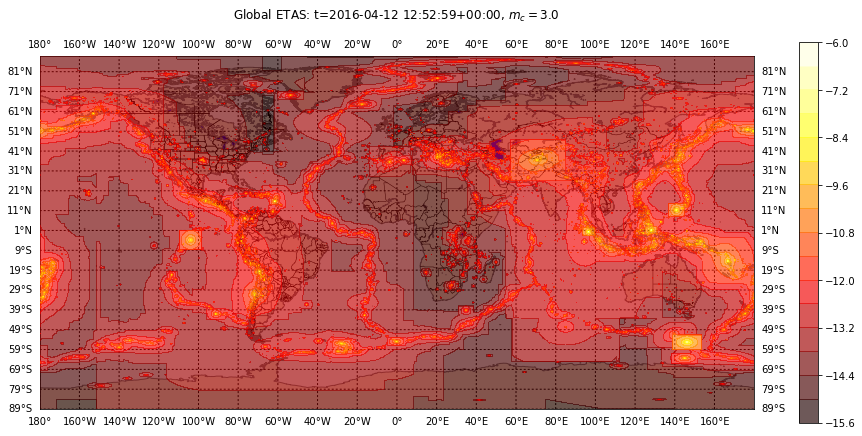

In [24]:


plt.figure(0, figsize=(16,14))
print('working... (this might take a while)...')
# nepal_figs.
CC = draw_global_etas_contours(xyz=xyz_output, fignum=0, cmap='hot')
plt.colorbar(shrink=.5)

print('working file: {}'.format(xyz_output))
#
# get header data:
header_data=''
with open(xyz_output, 'r') as fin:
    for rw in fin:
        if rw.startswith('#'):
            #rw.replace('\n', '\t')
            header_data = header_data + rw.replace('\n', '\t')[1:]
        else:
            break
    #header_data = header_data + fin.readline()
#
header_datas = header_data.split('\t')
#header_datas = {key:val for key,val in rw.split('=') for rw in header_datas}
header_datas = dict([rw.split('=') for rw in header_datas[2:] if len(rw.split('='))>=2])
#
plt.title('Global ETAS: t={}, $m_c={:.1f}$\n\n'.format(header_datas['t_now'], float(header_datas['mc'])))

print('hd: ', header_datas)

print('finishd.')


plt.savefig(os.path.join(revisions_data, 'global_etas_map_hot.png'))

print(xyz_output)

working... (this might take a while)...
**DEBUG lons:  (-180.0, 179.9) (-180.0, 179.9) (-89.0, 88.9)
**DEBUG lons:  (-89.0, 88.9) (-89.0, 88.9) (-89.0, 88.9)


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


cmap:  jet
working file: /home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/global_etas.xyz
hd:  {'lons': '[-180.0, 180.0]', 'mc': '3.0', 'd_lon': '0.1', 'd_lat': '0.1', 'etas_range_factor': '30.0', 'etas_range_padding': '1.0', 'etas_fit_factor': '1.5', 't_now': '2016-04-12 12:52:59+00:00', 'cat_len': '3650.0'}
finishd.


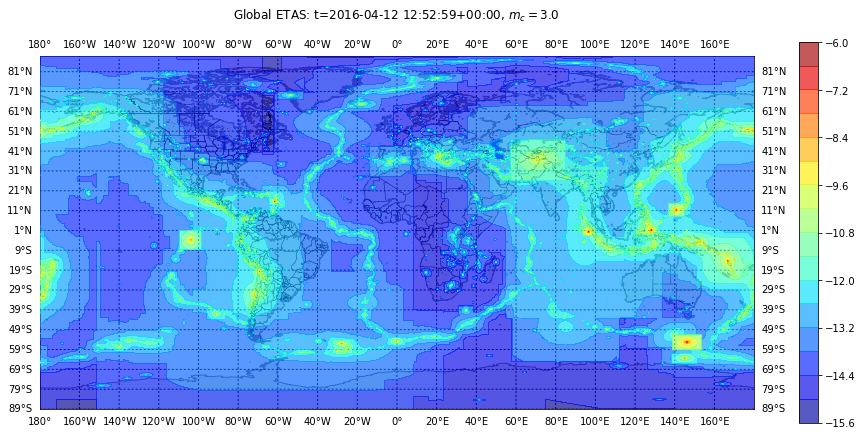

In [25]:
plt.figure(0, figsize=(16,14))
print('working... (this might take a while)...')
# nepal_figs.
# cmap_str='spectral'
cmap_str = 'jet'
CC = draw_global_etas_contours(xyz=xyz_output, fignum=0, cmap=cmap_str)
plt.colorbar(shrink=.5)
#
print('working file: {}'.format(xyz_output))
#
# get header data:
header_data=''
with open(xyz_output, 'r') as fin:
    for rw in fin:
        if rw.startswith('#'):
            #rw.replace('\n', '\t')
            header_data = header_data + rw.replace('\n', '\t')[1:]
        else:
            break
    #header_data = header_data + fin.readline()
#
header_datas = header_data.split('\t')
#header_datas = {key:val for key,val in rw.split('=') for rw in header_datas}
header_datas = dict([rw.split('=') for rw in header_datas[2:] if len(rw.split('='))>=2])
plt.title('Global ETAS: t={}, $m_c={:.1f}$\n\n'.format(header_datas['t_now'], float(header_datas['mc'])))
#
plt.savefig(os.path.join(revisions_data, 'global_etas_map_{}.png'.format(cmap_str)))

print('hd: ', header_datas)
          
print('finishd.')
#



get cataog:  [-180.0, 179.90000000000001] [-89.0, 88.900000000000006] 4.0 2016-04-12 13:00:00+00:00 2016-08-10 13:00:00+00:00
data handle fetched...
 no file.
catlen:  4604
[(4.0, 0.96917015471257639), (5.0, 0.96789089002661155), (6.0, 0.96171580384689903)]


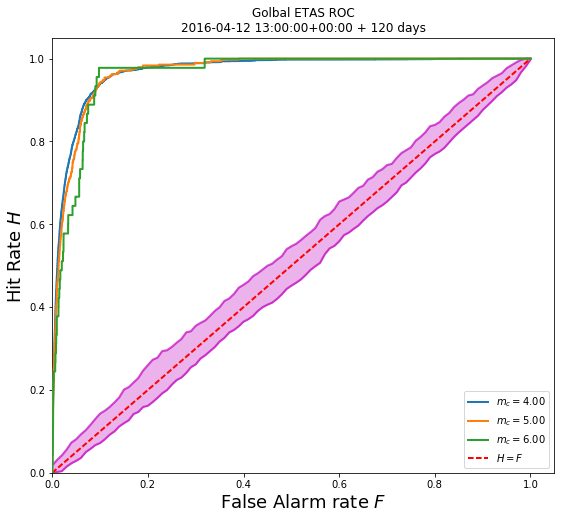

In [108]:
# TODO: we seem to be instantiating this at least a few times. subtle differences? it there maybe a more efficient
#  way to do this (maybe new instantiations for log-/lin-scale x?).
# TODO: also, wrap all of this into something we can pickle and save...
roc_glob = global_roc_from_optimizer(fc_xyz=xyz_output, fignum=0, mcs=[4.,5.,6.], fc_len=120, ls='-', 
                                     marker='', lw=2,
                                     etas_end_date=dtm.datetime(2016,4,12,13,tzinfo=nepal_figs.pytz.timezone('UTC')))
#
#print(len(roc_glob))
def integrate_FH(FH):
    # really just an integrate_XY. Assume input is XY = [[x,y], ...] like. numerically integrate...
    # for now, assume point-by-point integration; use center-bin averaging:
    #return numpy.sum([.5*(y2+y1)*(x2-x1) for (x1,y1), (x2,y2) in zip(FH[:-1], FH[1:])])
    #f,h = numpy.array(FH).T
    #
    #return numpy.sum(.5*(FH.T[1][1:]+FH.T[1][:-1])*(FH.T[0][1:]-FH.T[0][:-1]))
    return numpy.sum(.5*(FH.T[1][1:]+FH.T[1][:-1])*numpy.diff(FH.T[0]))
#
#%timeit 
print([(m,integrate_FH(numpy.array(fh))) for m,fh in roc_glob])
#

# def integrate_FH(FH):j
#     # NOTE: this list-comprehension approach consistently out-performs variations of the
#     #  above numpy. approaches above (3.85s vs 4.43s).
#     #
#     # really just an integrate_XY. Assume input is XY = [[x,y], ...] like. numerically integrate...
#     # for now, assume point-by-point integration; use center-bin averaging:
#     return numpy.sum([.5*(y2+y1)*(x2-x1) for (x1,y1), (x2,y2) in zip(FH[:-1], FH[1:])])
#     #f,h = numpy.array(FH).T
#     #return numpy.sum(.5*(h[1:]+h[:-1])*(f[1:]-f[:-1]))
# %timeit print([(m,integrate_FH(fh)) for m,fh in roc_glob])
# for global, this will be... HUGE, >600MB. the binary .pkl object (see below) is 500 MB.
# for publication, we can share an interpolated copy.
#with open(os.path.join(figs_data_path, 'global_roc_FH.json'), 'w') as f:
#    json.dump(roc_glob, f)

with open(os.path.join(figs_data_path, 'global_roc_FH.pkl'), 'wb') as f:
    pickle.dump(roc_glob,f)

3
[(4.0, 0.96917015471257639), (5.0, 0.96789089002661155), (6.0, 0.96171580384689903)]
[(4.0, 0.96917015471257639), (5.0, 0.96789089002661155), (6.0, 0.96171580384689903)]
[(4.0, 0.96917015471257639), (5.0, 0.96789089002661155), (6.0, 0.96171580384689903)]
[(4.0, 0.96917015471257639), (5.0, 0.96789089002661155), (6.0, 0.96171580384689903)]
1 loop, best of 3: 4.43 s per loop
[(4.0, 0.96917015471257639), (5.0, 0.96789089002661155), (6.0, 0.96171580384689903)]
[(4.0, 0.96917015471257639), (5.0, 0.96789089002661155), (6.0, 0.96171580384689903)]
[(4.0, 0.96917015471257639), (5.0, 0.96789089002661155), (6.0, 0.96171580384689903)]
[(4.0, 0.96917015471257639), (5.0, 0.96789089002661155), (6.0, 0.96171580384689903)]
1 loop, best of 3: 3.84 s per loop


### ROC geospatial ranges

In [28]:
# first, get all the ROC geospatials...
# there is, i think, another version of this script that should be faster (same module).
# (this version takes about a day at 8 x 1.77GHz)
#
do_roc_gs_calcs = False
#do_roc_gs_calcs = True
#
#f_path  = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/revs_201703/gs_roc_q_v_q'
#f_path  = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/gs_roc_q_v_q'\
f_path  = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/debug/data_n_figs/gs_roc_q_v_q'
#pth,fname = os.path.split(f_pkl)
if not os.path.isdir(f_path): os.makedirs(f_path)
#
f_pkl   = os.path.join(f_path, 'etas_roc_geospatial_FHs.pkl')
f_json  = os.path.join(f_path, 'etas_roc_geospatial_FHs.json')
f_csv   = os.path.join(f_path, 'etas_roc_geospatial_FHs.csv')

if do_roc_gs_calcs:
    # we had taken these all the way out to 3.5, but this metric optimizes at the lower q's so let'
    # save ourselves some compute time...
    q_t_min  = 1.1
    q_fc_min = 1.1
    q_t_max  = 2.5
    q_fc_max = 2.5
    #
    # note: for debugging, we might want to bump these up a bit...
    dq_fc = .1
    dq_t  = .1
    aa=nepal_figs.etas_roc_geospatial_raw(q_t_min=q_t_min, q_t_max=q_t_max, q_fc_min=q_fc_min, q_fc_max=q_fc_max,
                                   dq_fc=dq_fc, dq_t=dq_t, fignum=0, fout=f_csv)
    #aa=etas_analyzer.etas_roc_geospatial_raw(q_t_min=1.1, q_t_max=2.5, q_fc_min=1.1, q_fc_max=2.5,
    #                               dq_fc=.5, dq_t=.5, fignum=0, fout=f_csv)
    #
    plt.figure(0)
    plt.plot(range(2), range(2), ls='--', lw=2., color='r')
    #
    for j in list(range(0,8))+[42]:
        # getting somethien weird for fig. need to figure out what fig1 is and why it's acting weird...
        if j==1: continue
        plt.figure(j)
        plt.savefig(os.path.join(f_path, 'etas_roc_geospatial_raw_output_fig_{}.png'.format(j)))
    #
    # dump/save the data    
    #
    with open(f_pkl, 'wb') as fout:
        pickle.dump(aa,fout)

    # turns out these data sets aren't that big:
    with open(f_json, 'w') as fout:
        json.dump(aa,fout)
#######
# split here...
######

   

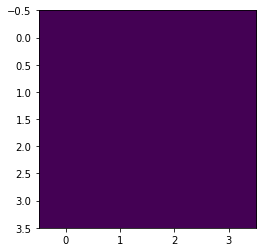

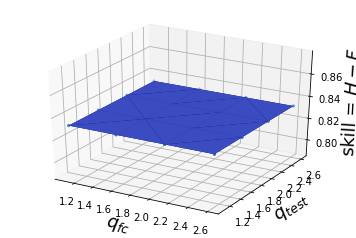

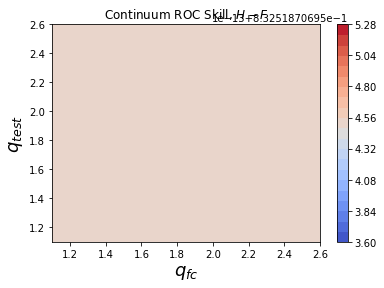

In [32]:
 

#f_path = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/gs_roc_q_v_q'
#f_json_dbg = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/debug/data_n_figs/gs_roc_q_v_q/etas_roc_geospatial_FHs.json'
#roc_gs_datas = json.load(open(f_json_dbg))
roc_gs_datas = json.load(open(f_json))
#
#print('loading roc_gs from: {}'.format(f_json))

#print(roc_gs_datas[0:3])
# eventually, start using this script (again); adapt it to accept either a tabular csv or a .json.
# q_q_skill_figs(data='data/roc_geospatial_nepal_q11_24_11_24.csv')

Xs=sorted(list(set([x for x,y,f,h in roc_gs_datas])))
Ys=sorted(list(set([y for x,y,f,h in roc_gs_datas])))
Zs=numpy.array(list([h-f for x,y,f,h in roc_gs_datas]))
#
Zs.shape=(len(Ys), len(Xs))
#
plt.imshow(Zs.transpose())



cc=nepal_figs.q_q_skill_figs(os.path.join(f_path, f_json), fignum=4)

### Gorkha ETAS with m>7 (like "regular" ETAS):


In [33]:
pram_updates   = {'mc':7., 'etas_range_factor':25, 'etas_range_padding':1.25 }
pram_updates_6 = {'mc':5.5, 'etas_range_factor':25, 'etas_range_padding':1.25 }
fc_gorkha_7 = etas_analyzer.get_nepal_etas_fc(n_procs=3, cat_len=30, p_cat=1.1, q_cat=1.5, 
                                    t_0 = dtm.datetime(2010,1,1, tzinfo=tz_utc), 
                                    t_now=dtm.datetime(2015,5,7, tzinfo=tzutc), **pram_updates)
fc_gorkha_6 = etas_analyzer.get_nepal_etas_fc(n_procs=3, cat_len=30, p_cat=1.1, q_cat=1.5, 
                                    t_0 = dtm.datetime(2010,1,1, tzinfo=tz_utc), 
                                    t_now=dtm.datetime(2015,5,7, tzinfo=tzutc), **pram_updates_6)

#

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (30.000000) = 2015-04-07 00:00:00+00:00
fetch and process catalog for dates: [datetime.datetime(2015, 4, 7, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(2015, 4, 7, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)], 'mc': 7.0, 'lons': [79.698, 89.698], 'lats': [23.175, 33.175], 'incat': None}
data handle fetched...
 no file.
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 1], None)
make_etas():
etas_mpp worker xyz_range:  [0, 3333]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (

/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


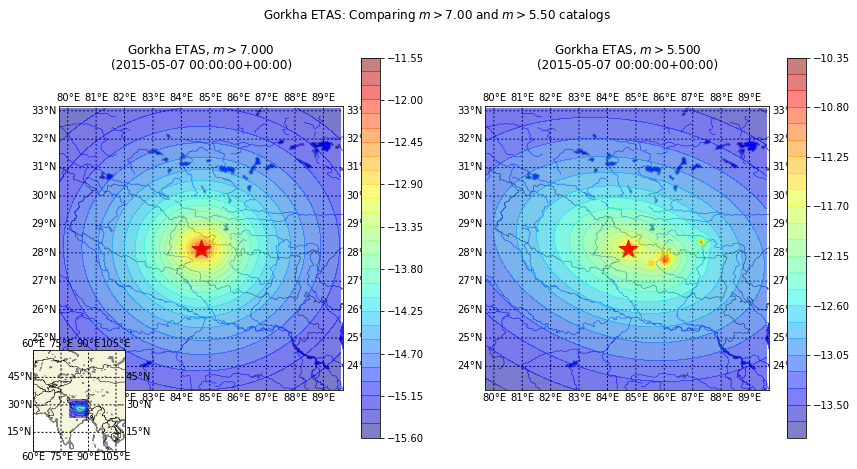

In [34]:
fg=plt.figure(0, figsize=(14,7))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
fc_gorkha_7.plot_mainshock_and_aftershocks(ax=ax1)
fc_gorkha_6.plot_mainshock_and_aftershocks(ax=ax2)
ax1.set_title('Gorkha ETAS, $m>{:.3f}$\n({})\n\n'.format(pram_updates['mc'], fc_gorkha_7.t_now))
ax2.set_title('Gorkha ETAS, $m>{:.3f}$\n({})\n\n'.format(pram_updates_6['mc'], fc_gorkha_7.t_now))
plt.suptitle('Gorkha ETAS: Comparing $m>{:.2f}$ and $m>{:.2f}$ catalogs'.format(pram_updates['mc'], pram_updates_6['mc']))
fg.savefig(os.path.join(revisions_data, 'nepal_fc_etas_m7_m6_contours.png'))
#
# draw an inset to show location:
ax_inset = fg.add_axes([.01, .1, .27, .2])
#
# TODO: how do we set the colormap for this plot?
cm_fc = neapl_etas_initial.make_etas_contour_map(ax=ax_inset, fig_size=(10,8), n_contours=25, lons_map=(60,110),
                                                 lats_map=(5,60), lon_interval=15, lat_interval=15, do_colorbar=False,
                                                do_states=False, do_rivers=False, lake_color=None,
                                                map_cmap='jet')


#cc=nepal_figs.q_q_skill_figs(os.path.join(figs_data_path, f_json), fignum=4)
fname_cat_6_7 = os.path.join(figs_data_path, 'gorkha_etas_m7_m6_comparison.png')
plt.savefig(fname_cat_6_7)
fname_cat_6_7 = os.path.join(revisions_data, 'gorkha_etas_m7_m6_comparison.png')
plt.savefig(fname_cat_6_7)

In [35]:
#plt.savefig(fname_cat_6_7)

In [36]:
print(revisions_data)

data/revisions_outputs


### Rotation validation and composite demo

etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 2.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': ['1990-1-1', None], 'mc': 2.5, 'lons': [-117.0, -114.0], 'lats': [32.0, 38.0], 'incat': None}
results fetched.
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-03-19 05:53:14.918554+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], None)
make_etas():
etas_mpp worker xyz_range:  [0, 300]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-03-19 05:53:14.918554+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], [0, 300])
etas_mpp worker xyz_range:  [300, 600]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3

/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 2.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7f1cc02db630>), datetime.datetime(2018, 3, 19, 0, 22, 50, 479250, tzinfo=<UTC>)], 'mc': 2.5, 'lons': [-117.0, -114.0], 'lats': [32.0, 38.0], 'incat': None}
results fetched.
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-03-19 05:53:14.918554+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], None)
make_etas():
etas_mpp worker xyz_range:  [0, 300]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-03-19 05:53:14.918554+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], [0, 300])
etas_mpp worker xyz_range:  [300, 600]


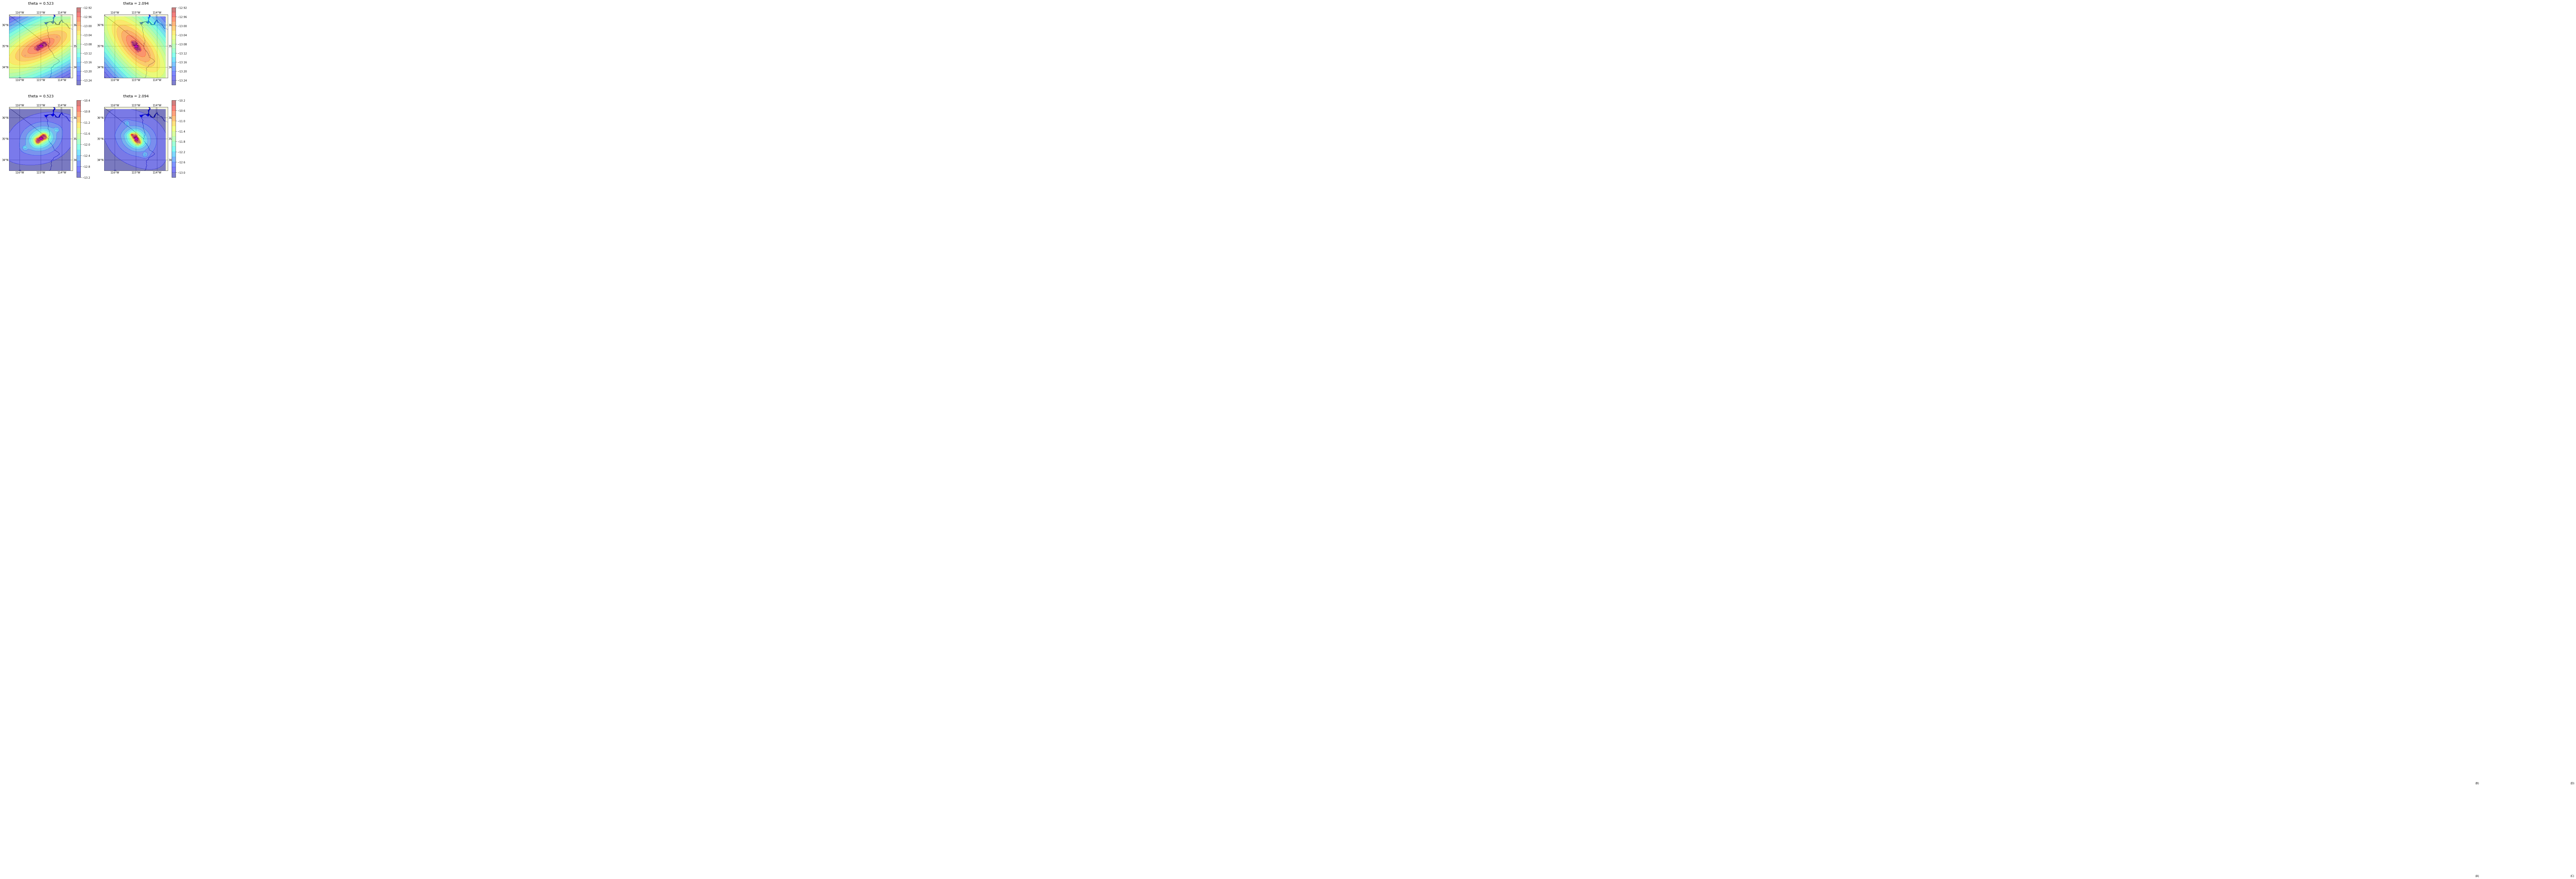

In [37]:
# make a toy catalog:
#N_ev=20, theta=3.14/4., m0=7., dm=3., lat0=35., lon0=-115., delta_t=2., t0=dtm.datetime(2016,1,1, tzinfo=tzutc)
N_ev=120
#theta=(1./6.)*3.14
m0=7.
dm=3.
lat0=35.
lon0=-115.
delta_t=2.
t0=dtm.datetime(2016,1,1, tzinfo=tzutc)
#
L_r = 10.**(.5*m0 - 1.76)
L = 3.5*L_r
#print('**L,L_r = ', L, L_r)
d_LL = L/111.1
y_scatter = 0.45
ab_ratio_expon=.5
#
R = random.Random()
r_factor=.2
km2_ll = 1./111.
m = m0-dm
m_ms = m0
#
#d_lat = km2_ll*L*math.sin(theta)/N_ev
#d_lon = km2_ll*L*math.cos(theta)/(N_ev*math.cos(lat0))
dt = dtm.timedelta(days=delta_t)
dy0=0.
#

fg=plt.figure(figsize=(12,12))
plt.clf()
#ax=plt.gca()
n_rw=2
n_cl=2
#
d_lat=1.5
d_lon=1.5
mylats = [lat0-d_lat, lat0+d_lat]
mylons = [lon0-d_lon, lon0+d_lon] 
#
letter_labels = ['(A)', '(B)', '(C)', '(D)']
#
for k,theta in enumerate([(x/6.)*3.141 for x in [1.,4.]]):
    #
    LLs = [[-.5*L/111.1,dy0], [.5*L/111.1, dy0]]
    LLs = numpy.array(LLs + [[(R.random()-.5)*L_r/(111.1*math.cos(lat0)), dy0 + (R.random()-.5)*y_scatter*L_r/111.1] for j in range(N_ev)])
    #
    M_r = numpy.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]]).T
    #
    LLs = numpy.dot(LLs, M_r)
    #
    cat = []
    #
    for j, (lon,lat) in enumerate(LLs):
        cat += [[t0+dt*j, lon+lon0, lat+lat0, m, mpd.date2num(t0+dt*j) ]]
    #
    tms = cat[int(.5*len(cat))][0]
    #cat += [[cat[-1][0]+dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
    #        mpd.date2num(cat[-1][0]+dt) ]]
    # add a mainshock:
    ms_lon, ms_lat = numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat])
    #cat += [[tms+.5*dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
    cat += [[tms+.5*dt, ms_lon, ms_lat, m_ms, mpd.date2num(tms+.5*dt) ]]
    #
    #
    cat = numpy.core.records.fromarrays(zip(*cat), dtype = [('event_date', 'datetime64[us]'),
                                                                    ('lon', '>f8'), ('lat', '>f8'), ('mag', '>f8'),
                                                                   ('event_date_float', '>f8')])
    cat_original = cat.copy()
    #
    ######################################
    ######################################
    #
    gep_cat = cat_original.copy()
    # add a mainshock (assign a large magnidute to the middle event):
    #gep_cat[int(len(gep_cat)/2)]['mag'] +=3.
    gep_cat = gep.make_ETAS_catalog_mpp(incat=gep_cat, fit_factor=2.5)
    #
    # get just the mainshock:
    max_mag = max(gep_cat['mag'])
    rw = gep_cat[0]
    for rw in gep_cat:
        if rw['mag']>=max_mag:
            ms_cat = numpy.array([rw], dtype=gep_cat.dtype)
            mainshock = rw
            break
    #
    ax1 = plt.subplot('{}{}{}'.format(n_rw, n_cl, k+3))
    ax2 = plt.subplot('{}{}{}'.format(n_rw, n_cl, k+1))
    #
    ms_etas1 = gep.ETAS_mpp(catalog=ms_cat, lats=mylats, lons=mylons, ab_ratio_expon=ab_ratio_expon, ab_ratio_max=2.)
    ms_etas = gep.ETAS_mpp(catalog=gep_cat, lats=mylats, lons=mylons, ab_ratio_expon=ab_ratio_expon, ab_ratio_max=2.)
    #print('***Debug: lats_lons::  ', mylats, mylons)
    #
    ms_etas.make_etas_contour_map(ax=ax1, lats_map=mylats, lons_map=mylons)
    ms_etas1.make_etas_contour_map(ax=ax2, lats_map=mylats, lons_map=mylons)
    #
    #new_etas.cm.scatter(*zip(*xy_prime), 'o', edgecolors='b', c='none', s=18)
    #new_etas.cm.plot(gep_cat['lon'], gep_cat['lat'], marker='o', color='b', zorder=7, latlon=True)

    #plt.figure()
    ax1.plot(gep_cat['lon'], gep_cat['lat'], marker='o', ls='', color='b', zorder=7, alpha=.1)
    ax1.plot([ms_lon], [ms_lat], marker='*', color='k', ms=18, zorder=11)
    ax1.plot([ms_lon], [ms_lat], marker='*', color='m', ms=16, zorder=11)
    ax2.plot(gep_cat['lon'], gep_cat['lat'], marker='o', ls='', color='b', zorder=7, alpha=.1)
    ax2.plot([ms_lon], [ms_lat], marker='*', color='k', ms=18, zorder=11)
    ax2.plot([ms_lon], [ms_lat], marker='*', color='m', ms=16, zorder=11)
    #
    ax1.set_title('theta = {:.3f}\n\n'.format(theta), size=14)
    ax2.set_title('theta = {:.3f}\n\n'.format(theta), size=14)
    #
    ax1.text(.1,.1, letter_labels[2*k])
    ax2.text(.1,.1, letter_labels[2*k+1])
#fg.set_figheight(12)
#fg.set_figwidth(12)

fg.savefig('/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/orientation_demo_quad.png')

working... (this might take a while)...
**DEBUG lons:  [-123.0, -90.2] (-180.0, 179.9) [30.0, 45.0]
**DEBUG lons:  [30.0, 45.0] (-89.0, 88.9) [30.0, 45.0]


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


cmap:  jet
working file: /home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/global_etas.xyz
hd:  {'lons': '[-180.0, 180.0]', 'mc': '3.0', 'd_lon': '0.1', 'd_lat': '0.1', 'etas_range_factor': '30.0', 'etas_range_padding': '1.0', 'etas_fit_factor': '1.5', 't_now': '2016-04-12 12:52:59+00:00', 'cat_len': '3650.0'}
finishd.


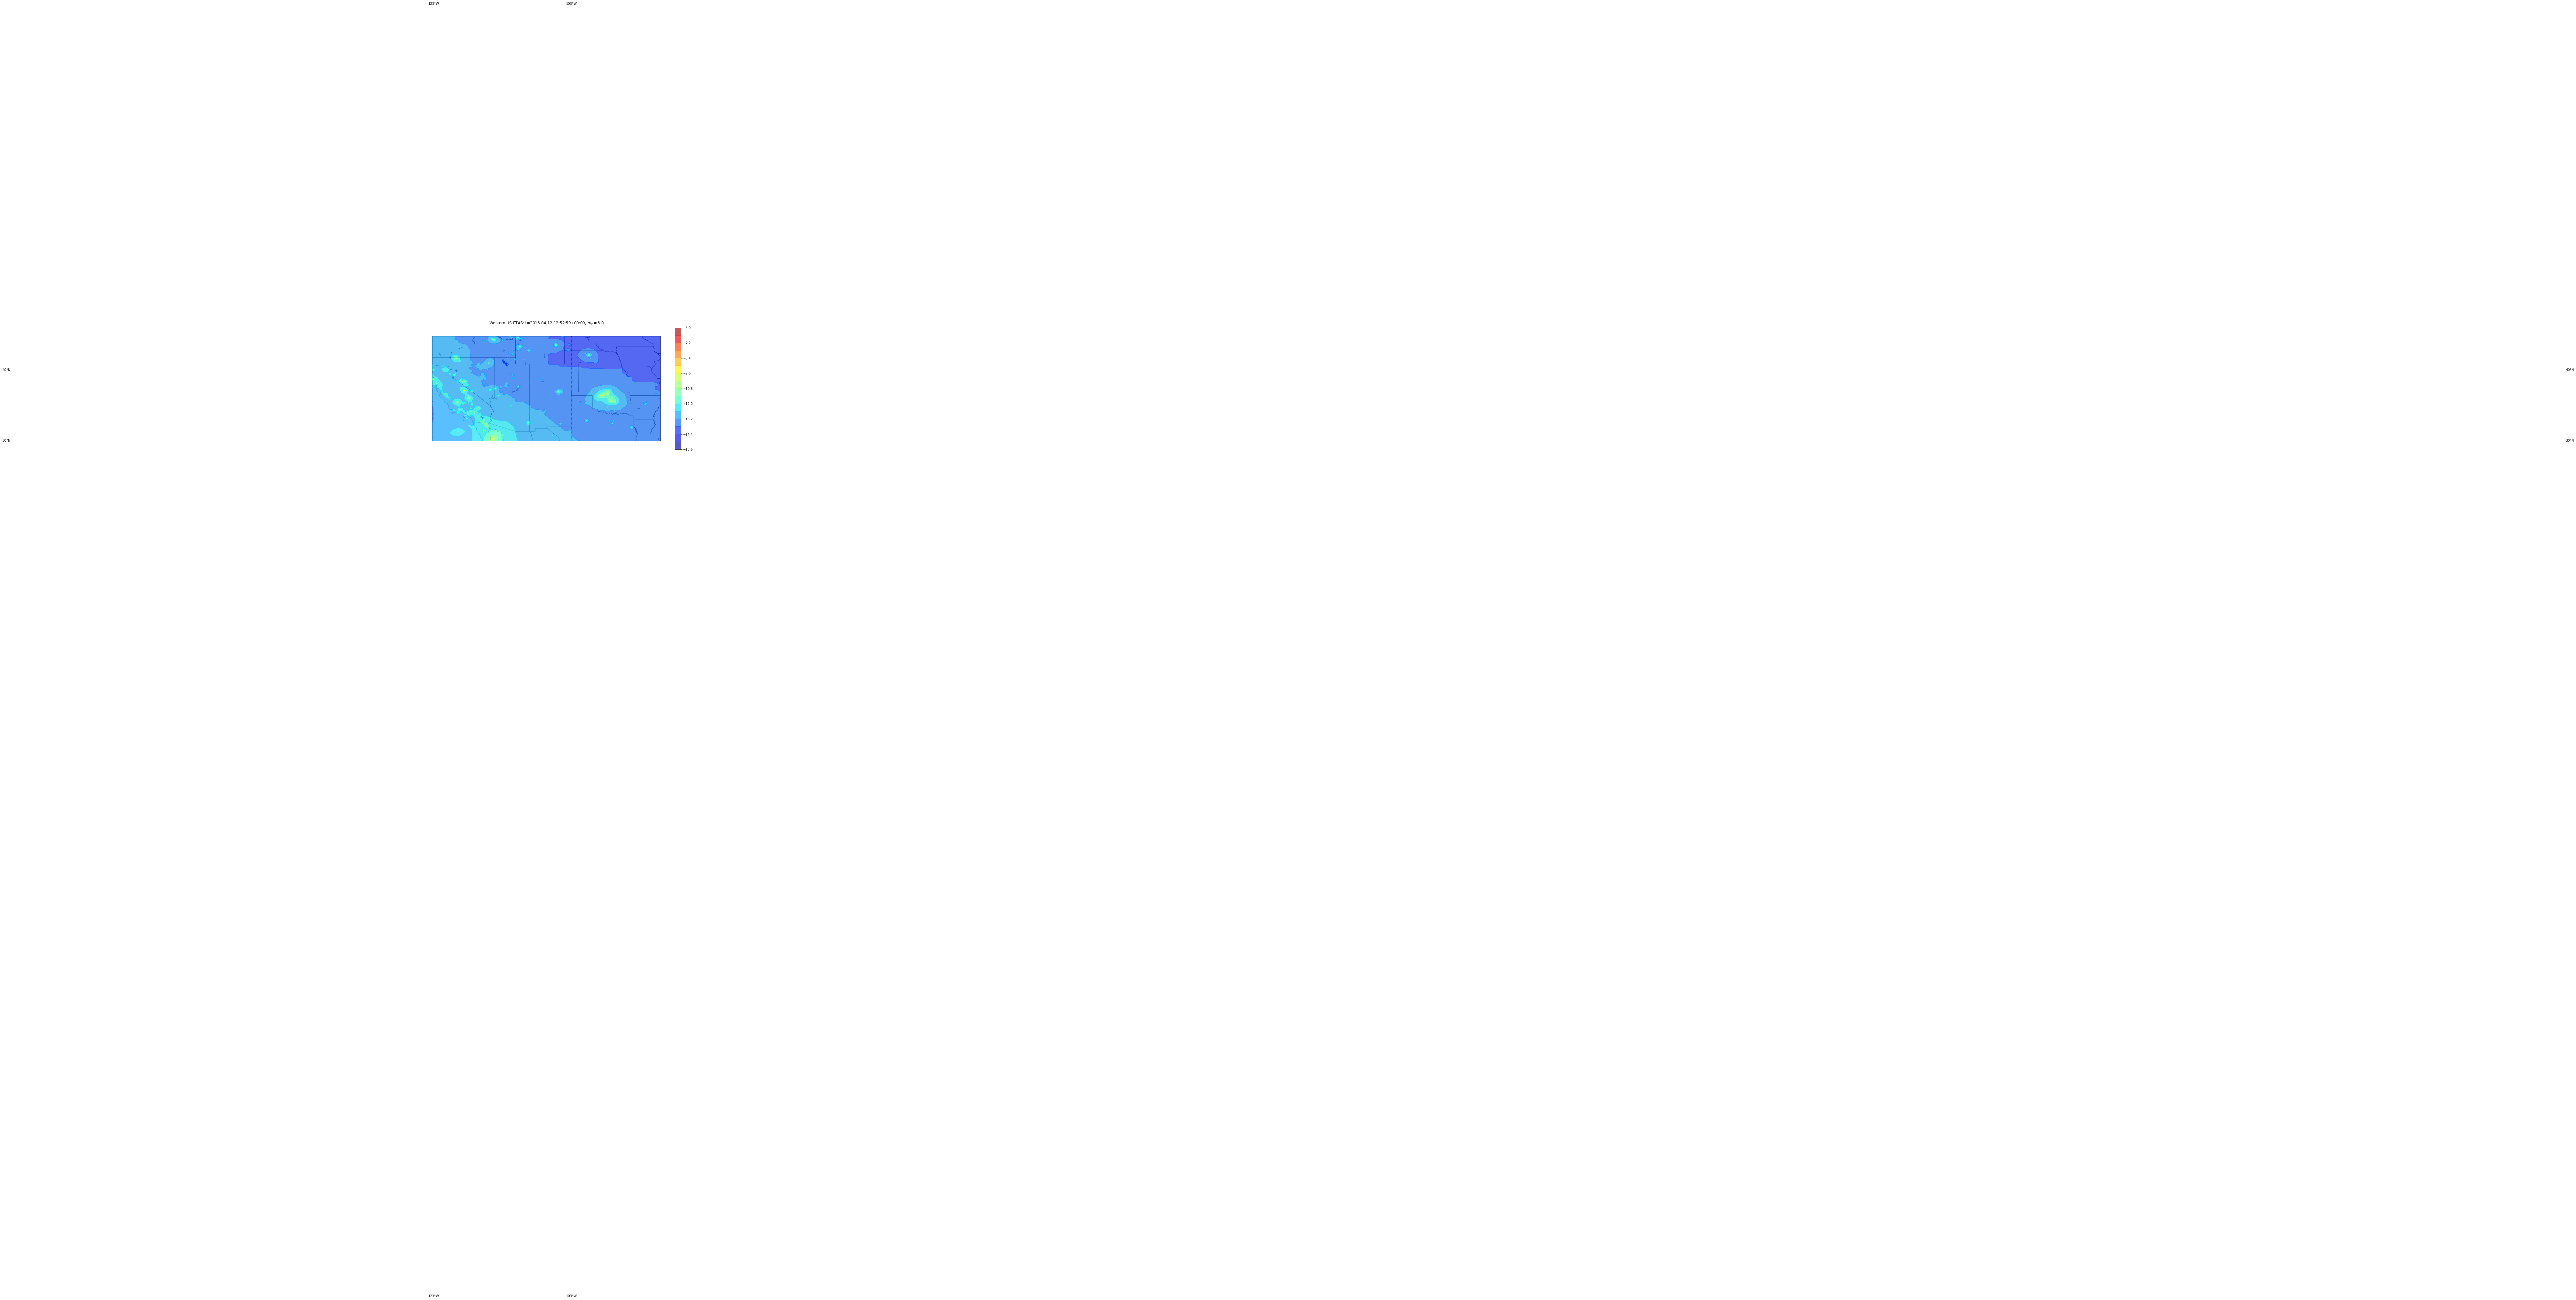

In [38]:
###
# let's get an OK (western US) from our new global ETAS:
plt.figure(0, figsize=(16,14))
print('working... (this might take a while)...')
# nepal_figs.
# rewrite or modify this to draw a map over a smaller spatial domain:
# from nepal_figs:
#mm = Map_drawer(xyz=xyz_output, map_lats=[30., 45.], map_lons=[-123., -90.2])
cmap_str = 'jet'
#cmap_str = 'spectral'
map_lons=[-123., -90.2]
map_lats=[30., 45.]
CC = draw_global_etas_contours(xyz=xyz_output, map_lats=map_lats, map_lons=map_lons, 
                               fignum=0, cmap=cmap_str, do_colorbar=False)
#ax = plt.gca()
#ax.set_ylim(map_lats)
#ax.set_xlim(map_lons)
plt.colorbar(shrink=.5)
#
print('working file: {}'.format(xyz_output))
#
# get header data:
header_data=''
with open(xyz_output, 'r') as fin:
    for rw in fin:
        if rw.startswith('#'):
            #rw.replace('\n', '\t')
            header_data = header_data + rw.replace('\n', '\t')[1:]
        else:
            break
    #header_data = header_data + fin.readline()
#
header_datas = header_data.split('\t')
#header_datas = {key:val for key,val in rw.split('=') for rw in header_datas}
header_datas = dict([rw.split('=') for rw in header_datas[2:] if len(rw.split('='))>=2])
plt.title('Western US ETAS: t={}, $m_c={:.1f}$\n\n'.format(header_datas['t_now'], float(header_datas['mc'])))
#
plt.savefig(os.path.join(revisions_data, 'US_west_etas_map_{}.png'.format(cmap_str)))

print('hd: ', header_datas)
          
print('finishd.')
#


begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2010-05-08 00:00:00+00:00
fetch and process catalog for dates: [datetime.datetime(2010, 5, 8, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(2010, 5, 8, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)], 'mc': 3.5, 'lons': [79.698, 89.698], 'lats': [23.175, 33.175], 'incat': None}
data handle fetched...
 no file.
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 288], None)
make_etas():
etas_mpp worker xyz_range:  [0, 3333]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catl

/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


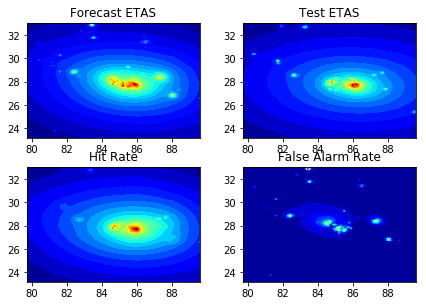

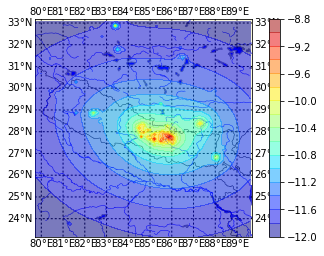

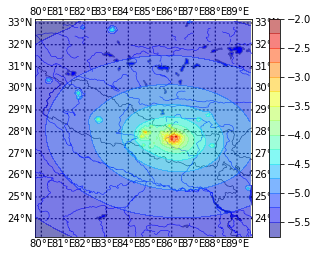

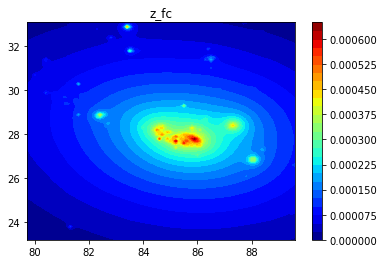

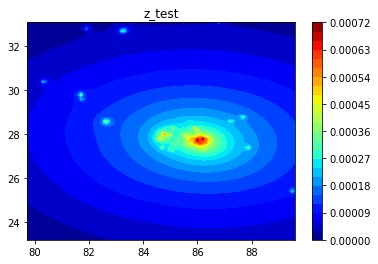

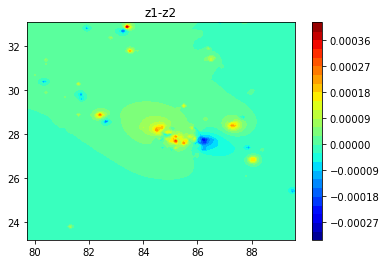

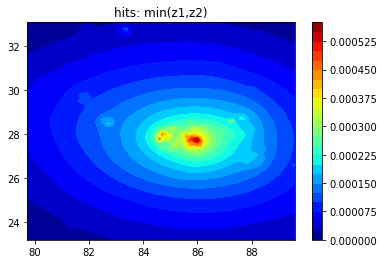

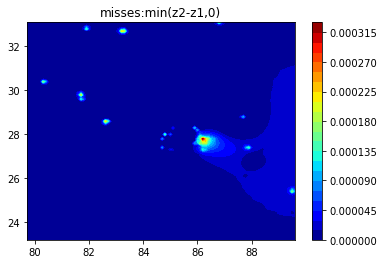

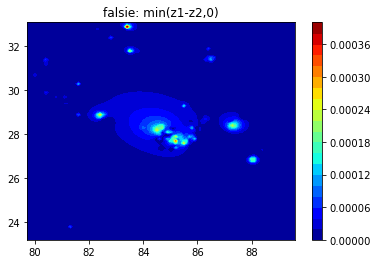

In [39]:
# and get the gs_roc_quad separately (because the full script bit is a huge pain):
gs_etas = etas_analyzer.analyze_etas_roc_geospatial(etas_fc=None, etas_test=None, do_log=True, diagnostic=False)
#

plt.figure(42)
plt.savefig(os.path.join(revisions_data, 'geospatial_ROC_quad_{}.png'.format(cmap_str)))

/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


FH2:  [0.068650191773775876, 0.93134980822622637]


TypeError: 'Text' object is not callable

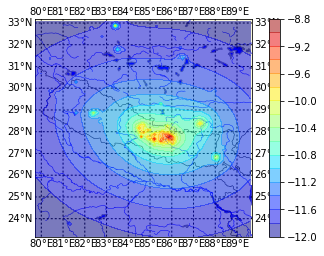

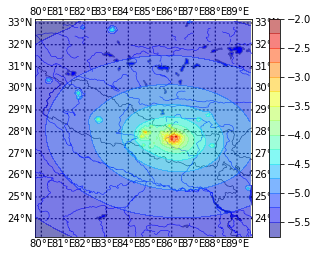

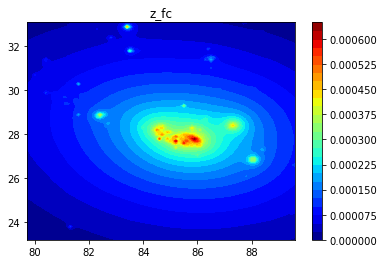

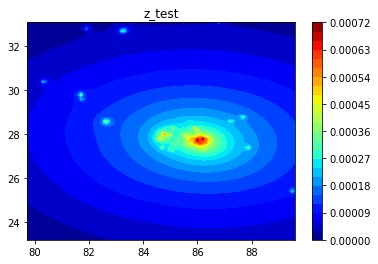

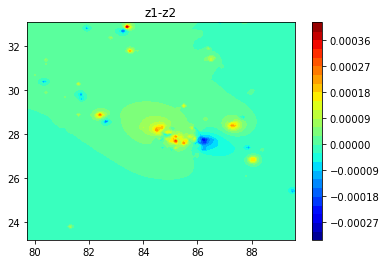

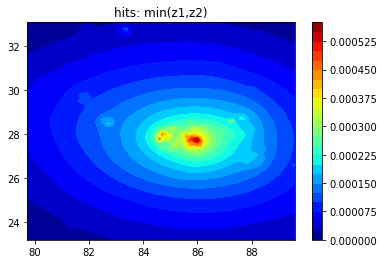

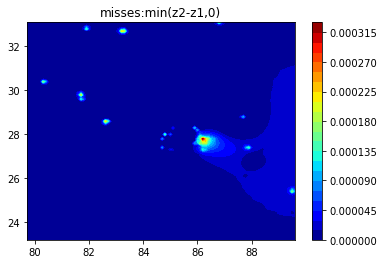

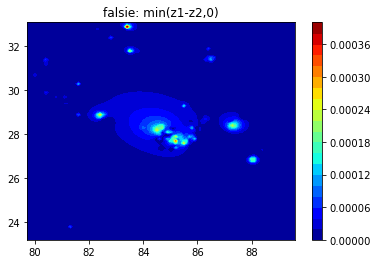

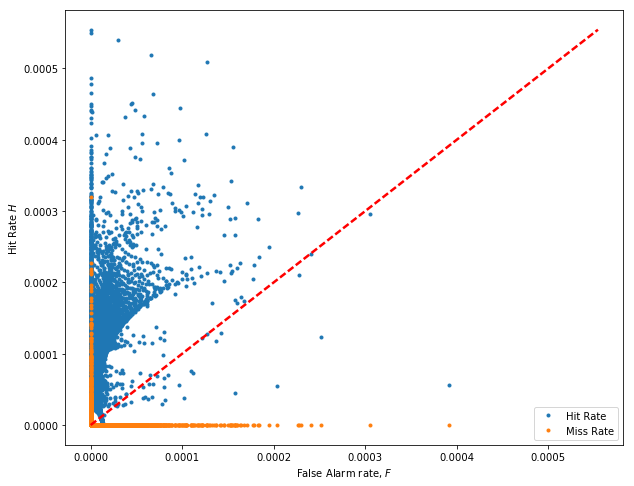

In [82]:
# TODO: construct a normalized GS ROC array, where we compute a normalized ROC for each cell; we want
# to evaluate the ROC for each cell independently.
FH2 = etas_analyzer.Analyze_ETAS_roc_geospatial(etas_fc=nepal_etas_fc, etas_test=nepal_etas_test,
                                                do_log=True, cmap='jet')
FH2.plot_quad()
print('FH2: ', FH2)
#
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.plot(FH2.f, FH2.h, ls='', marker='.', label='Hit Rate')
ax.plot(FH2.f, FH2.m, ls='', marker='.', label='Miss Rate')
x0 = max(max(FH2.f), max(FH2.h))
ax.plot([0., x0], [0., x0], ls='--', color='r', lw=2.5, marker='')
ax.set_xlabel('False Alarm rate, $F$')
ax.set_ylabel('Hit Rate $H$')
ax.legend(loc=0, numpoints=1)
ax.title('Gorkha gsROC')

#
x0 = max(max(FH2.f), max(FH2.h))
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.plot(FH2.f/x0, FH2.h/x0, ls='', marker='.', label='Hit Rate')
#ax.plot([0., x0], [0., x0], ls='--', color='r', lw=2.5, marker='')
ax.plot(range(2), range(2), color='r', lw=2., ls='--', marker='')
ax.set_xlabel('False Alarm rate, $F$')
ax.set_ylabel('Hit Rate $H$')
ax.legend(loc=0, numpoints=1)
ax.title('Gorkha gsROC (Globally Normalized)')


#### Locally Normalized gsROC:
- The idea here is to evaluate the ROC performance of each cell independently, but this is nominally challenging.
- Nominally, we want to normalize the gsROC cells in the same spirit as standard ROC:
  - $h \sim z_{hits}/z_{test}$, $f \sim z_{false}/z_{predicted}
    - ... where $z_{hit}$ and $z_{false}$ are computed as per the gsROC description.
- The problem is that this yields $roc_{norm} = {1,0}:
  - If we over-predict, $z_{fc} > z_{test}$, we get $h=1$ and $0 < f < 1$.
  - if we under-predict, $z_{fc} < z_{test}$ we get $0 < h < 1$, $f=0$
- So, we either under-predict with no false alarm or we over-predict with no misses, and the normalized ROC nominally looks like a perfect forecast. 
  - We might come up with a normalization and ROC variant that basically counts the number of elements in the $f=0$ group -- something more like a Molchan, not ROC, metric.
  - Otherwise, we stick with some sort of global normalization (over the study area). This nominally makes more sense, since it gives added weight to high activity domains.
  

sum:  0.806770434907 0.816501968577


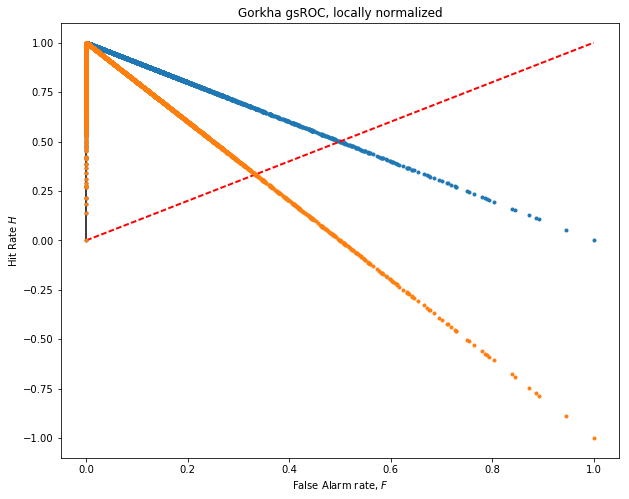

In [83]:
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.plot(FH2.roc_vecs_normed['falsie'], FH2.roc_vecs_normed['hits'], ls='',marker='.')
ax.plot(range(2), range(2), ls='--', lw=2., color='r')
#ax.set_xlim(-.05, .03)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAmoAAAHVCAYAAABBptdCAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAIABJREFUeJzs3Xl4lNXd//H3mUmCoAgBF8CwGBFUsLaBStyltbb6o6XF%0AXVq17i19+lS78diWWp7W2kVrF1qr1FYtoiK41EerYt1rFBIXQMtiJBBA1hCRAMnMnN8fZ2YyM5lM%0A7iST3DPJ53Vducg9meVMSpmP33PO9xhrLSIiIiKSewJ+D0BERERE0lNQExEREclRCmoiIiIiOUpB%0ATURERCRHKaiJiIiI5CgFNREREZEcpaAmIiIikqMU1ERERERylIKaiIiISI4q8HsA2XDQQQfZUaNG%0A+T0MERERkTZVVlZus9Ye7OW+PSKojRo1iqVLl/o9DBEREZE2GWNqvN5XU58iIiIiOUpBTURERCRH%0AKaiJiIiI5CgFNREREZEcpaAmIiIikqMU1ERERERylIKaiIiISI5SUBMRERHJUQpqIiIiIjlKQU1E%0AREQkRymoiYiIiOQoBTURERGRHKWgJiIiIpKjFNREREREcpSCmoiIiEiOUlATERERyVEKah5V1tQx%0A57k1VNbU+T0UERERybZQCLZt83sULRT4PYB8UFlTx/S5FTSGIhQVBJh3ZTkTRhb7PSwRERHJhs2b%0A4cILYfdueOkl6NPH7xHFqaLmQUX1dhpDESIWmkIRKqq3+z0kERERyYatW6GsDJ5/HpYsgV/9yu8R%0AJVFQ86C8dDAFAYMBggFDeelgv4ckIiIi2XDwwXD22e77r3wFrr/e3/GkUFDzypjkP0VERCQ/7d7t%0AKmgxv/89zJ8Pd98N/fr5Nqx0FNQ8qKjeTigcwQLhsKY+RURE8taqVVBeDmedBW+84W7bbz+3Ri0H%0AizEKah6Ulw6mqCBA0EBhQUBTnyIiIvnokUfgk5+E5cth715XSctx2vXpwYSRxcy7spyK6u2Ulw7W%0Ajk8REZF8EgrBj34EN9/cfNvMmfC//+vfmDxSUPNowshiBTQREZF8s3cvTJkCzz7rrg88EO65B6ZO%0A9XdcHimoiYiISM+1335w+OHu+/HjYdEiOPJIf8fUDgpqOaiypk7TrCIiIh1lLaxeDWPGuOvf/x6G%0ADYPvfQ/239/fsbWTglqO0SkIIiIindDQANdeCwsWwKuvwsc/7qpqP/mJ3yPrEO36zDE6BUFERKSD%0A3nsPTjgB7r3XrU37r/9y1bU8pqCWY9QKREREpAP+8Q+YMAHefttdn3YaPPRQTvZGaw9NfeYYtQIR%0AERFpB2th1iz46U+bb/vud+Gmm6Ag/2NO/r+DHkitQERERDwyBjZtct8fcAD87W9wzjm+DimbFNRE%0AREQk/9TXw4AB7vs//AH27HFNbY86yt9xZZnWqImIiEj+sBbuuANGjYI333S37bcfzJvX40IaKKiJ%0AiIhIvtizB664Aq65BnbudAeph0J+j6pLaepTREREct/777u1Z2+84a6HDIG5c3vEhoFMVFETERGR%0A3Pbkk671RiyknXIKVFXBySf7O65uoKAmIiIiuW3RIqirc99fd507YH3oUH/H1E16dr1QRERE8lMk%0AAoFoPen3v4dVq2DGDDj/fH/H1c1UURMREZHcUlUF48cn7+p8/vleF9JAQU1ERERyyV13wYknwrvv%0Aus0Du3a52/P8KKiOUlCTtCpr6pjz3Boqa+r8HoqIiPQGe/fC1Ve79hv79kEwCF//ujttoBfTGjVp%0AobKmjulzK2gMRSgqCDDvynIdaSUiIl2npsZVzyor3fUhh8CDD7qD1Xs5VdSkhYrq7TSGIkQsNIUi%0AVFRv93tIIiLSk916a3NIO/FEt0ZNIQ1QRU3SKC8dTFFBgKZQhMKCAOWlg/0ekoiI9GQ33wwvv+z6%0Aov3qV1BU5PeIcoaCmrQwYWQx864sp6J6O+WlgzXtKSIi2VVX546B+sEP4LjjoG9feOkl6NfP75Hl%0AHAU1SWvCyGIFNBERyb4333Tr0aqr3RTn0qUwcKBCWiu0Rk1ERES6xz33wAknuJAGrldaL2274ZWC%0AmvRKaj8iItKN9u2Dr30NLr3UteEIBODnP3dHQw0Y4PfocpqmPqXXUfsREZFudsstcPvt7vuDD4b5%0A8+HTn/Z3THlCFTXpddR+RESkm113HXziEzBpkmvDoZDmmYKa9Dqx9iNBg9qPiIh0hUgEfvELeOst%0Ad923LzzxBLzwAgwf7u/Y8oyx1vo9hk6bOHGiXbp0qd/DkDxSWVOn9iMiIl1h5063Fu2xx6C01O3q%0ALNa/s4mMMZXW2ole7uupomaM+ZwxZqUxZo0xZmaanxtjzO+iP3/bGFPW1mONMYOMMc8YY1ZH/yyO%0A3j7KGLPHGPNm9Ot2L2MUaY8JI4uZMXm0QpqISDYtWwaf/KQLaeB2dG7d6u+Y8lybQc0YEwTmAGcB%0AxwAXGWOOSbnbWcCR0a+rgT95eOxM4Flr7ZHAs9HrmPestR+Pfl3b0TcnIiIi3WTePLcGbc0ad/35%0Az7tq2pgx/o4rz3mpqB0PrLHWVltrG4H7gakp95kK3GOdCmCgMWZoG4+dCtwd/f5u4IudfC8iIiLi%0Ah/nz4ctfhj17XBXtpz+FRx5xjWylU7wEtcOA9QnXtdHbvNwn02MPtdZuin7/AXBowv0Oj057vmCM%0AOSXdoIwxVxtjlhpjlm5VWVVERMQ/X/yi29U5eDD885/uaKiA9itmQ070UbPWWmNMbFfDJmCEtXa7%0AMWYC8IgxZpy19sOUx9wB3AFuM0H3jlhERKSXe+45F8w+9jG3q3PRIldNGznS75H1KF7i7gYgcS9t%0ASfQ2L/fJ9NjN0elRon9uAbDW7rPWbo9+Xwm8B2iCW0REJBdYC7/6FZxxBkyb5nZ5AowapZDWBbwE%0AtSXAkcaYw40xRcCFwGMp93kMuCS6+7McqI9Oa2Z67GPApdHvLwUeBTDGHBzdhIAxphS3QaG6w+9Q%0AREREsuPDD+Hcc+F733O90mprYckSv0fVo7U59WmtDRljvgE8BQSBu6y1K4wx10Z/fjvwBHA2sAZo%0AAL6a6bHRp74ZeNAYcwVQA5wfvf1UYLYxpgmIANdaa3dk5d2KiIhIx6xY4Spoq1a561GjYOFCKCvL%0A+DDpHDW8FRERkcwqKtxU5+7d7vqss+Dvf4dBg/wdV57KesNbERER6cWOOw6OPNJtFrjxRnj8cYW0%0AbpITuz5FREQkx2za5DYKHH2029W5cCGsXOmqadJtFNQ80tmQIiLSa7z0Epx/PhxwgNssMHCgO7ez%0AtNTvkfU6mvr0oLKmjulzK7jl6ZVMn1tBZU2d30MSERHJPmvh1lth8mT44AN3HNR99/k9ql5NQc2D%0AiurtNIYiRCw0hSJUVG/3e0giIiLZtWsXXHABfPvbEA5Dnz5w553w9a/7PbJeTVOfHpSXDqaoIEBT%0AKEJhQYDy0sF+D0lERCR71q2Dz30O3n3XXY8cCQ89BBM9bUyULqSg5sGEkcXMu7Jca9RERKRnOvhg%0AV0ED+OxnYd48dzyU+E5BzaMJI4sV0EREpOcIhdzOzuHDm3d13ncf/M//QDDo9+gkSmvUPKqsqWPO%0Ac2u0kUBERPLfBx+4BraTJzef1VlaCj/8oUJajlFFzYPYrs/GUISiggDzrixXdU1ERPLTK6/Aeee5%0AahrAT38Kv/61v2OSVqmi5oF2fYqISN6zFn73Ozj99OaQdumlMHu2r8OSzFRR80C7PkVEJK/t3g1X%0AXQXz57vrwkL4/e/h6qvdsVCSsxTUPNCuTxERyWuBQHPrjZIS13pj0iR/xySeKKh5pF2fIiKSd3bv%0Ahv33b97V+b3vwZ/+5NpxSF7QGjUREZGeJhSCmTPhE59I3tX50EMKaXlGQU1ERKQn2bIFzjwTfvEL%0AWL0a/uu//B6RdIKmPkVERHqKigo491zYsMFdjx8Ps2b5OybpFFXUPFLDWxERyVnWwh//CKee2hzS%0Apk93we3II/0dm3SKKmoe9OaGt5U1ddrtKiKS6xob4Y47oKkJCgrgttvg619X640eQEHNg3QNb3tD%0AaOnNAVVEJC9Y68JYnz5uV+fUqS6wnXii3yOTLNHUpwexhrdBQ69qeKsTGUREcthjj7leaPX17vqI%0AI+DttxXSehhV1DzorQ1vdSKDiEgOCofdBoGbbnLXl10Gixa5ylpA9ZeeRkHNo97Y8La3BlQRkZy1%0AbRtcdBEsXuyu+/eHL39Za9F6MAU1yag3BlQRkZz0+uuu9cb69e76mGNcJW3sWH/HJV1KNVIREZFc%0AZ61rXBsLaRdeCK+9ppDWCyioiYiI5Dpj4L773PFPv/2t+/6AA/welXQDBTUREZFcVF0N552XvKvz%0Avffgm9/UmrReRGvUehA1pxUR6SH+7//cJoGdO10T20WL3I7O/v39Hpl0MwU1j3I9BN332jpmPbqc%0AcMTSp1DNaUVE8lI4DLNnu6+YI46ASEStN3opBTUPcr1Df2VNHbMeXU4oYgFobOo9pyeIiPQY27e7%0A8zmfespd778/3HUXnH++v+MSXymee5DYob8xBzv0V1RvJ2Jt/DoQMGpOKyKSby6/vDmkHXUULFmi%0AkCYKal4U9ysiWqwiYt11LomdIBAwUBAwzJ46XtU0EZF8c+utMGCA65X2+utw9NF+j0hygKY+Pahr%0AaMQAFpds6xoafR5Rsp5ygkCurwMUEcmqvXvhpz+F737XBbQjjoDKSigt1a5OiVNQ86C8dDB9CnP7%0AzMt8P0Eg19cBiohk1dq1rnJWWQkrVjSf1XnEEX6PTHKMpj49mDCymFlTxnHi6IOYNWVcXgSIypo6%0A5jy3hsqaOr+H4kniOsCmHFwHKCKSNU89BRMmuJAGsGULfPihv2OSnKWKmgeVNXXc+NhymsKW16q3%0AM3ZI/5wOa/lYnYqts8vlqqWISKdEIvCzn8GPf+yOhALXvPZXv4Ki3Fr7LLlDFTUPFlbV0hi2WKAx%0AbLn9hff8HlJG+Vidiq2zu/7MsXkRLEVE2u1734NZs1xI69fPHQP1298qpElGCmoepC7p/Nd/tuT0%0AlGKsOhU05FV1asLIYmZMHq2QJiI909e+5jYNHHmkO1D9oov8HpHkAQU1D6aVlRAMNMc1G7E5XaVS%0AdUpEJEc8+GDyWZ3//KfrjzZ+vL/jkryhoObBhJHF/O/U8RQEDAGgqDD3q1SqTomI+GjfPrj2Wrjg%0AAvjqV5vXpJWXu6qaiEfaTODRxZNGMHZI/x7V50t9y0REusC6da71xpIl7vrll6GmBkaN8nVYkp8U%0A1NohF3qVZStc5ePOUBGRnLd4MVx4oTu3E1wFbcECKCnxd1yStxTUPMqF6lM2w1W6naEKaiIinfDX%0Av8KVV7o2HAAzZrhjobSrUzpBQc2DXKk+ZTNcqW+ZiEiWnXIK9O8PjY1wxx3w5S/7PSLpARTUPMiV%0A6lM2w1VPOR9URMRXy5fDiBFw4IEwerTb5TlkCHzsY36PTHoIBTUPcqX6lO1wlQtr7kRE8ta8eXDV%0AVfC5z8HChe6szjPP9HtU0sMYG9synMcmTpxoly5d2qWvkQtr1EREJAc0NsL118OcOe46EIBXXnEb%0AB0Q8MMZUWmsnermvKmoiIiJe1dbCeedBRYW7PuggmD9fIU26jIKaB7mymUBERHz073/DF78IW7e6%0A609+Eh56yK1RE+kiOpnAg3w85FxERLLskEPctCfANdfASy8ppEmXU0XNg1zZTCAiIt2svt5tEojt%0A6rz3Xti2zR0LJdINFNQ8UCsLEZFeaPlymDYNjj3WTXEaA5//vN+jkl5GQc0jtbIQEelF5s93pww0%0ANMDq1e4YqPPP93tU0gtpjZqIiEhMUxN861tw8cUupBkDs2e7Q9ZFfKCKmoiICMCmTa71xiuvuOtB%0Ag1xT2899zt9xSa+moCYiIgLw0UewbJn7vqzMnTYwapSvQxLR1KeIiPRe1sLeve77I4+Ee+6BK65w%0AVTWFNMkBqqiJiEjvtGsXXH45RCLNuzqnTnVfIjlCFbVeqLKmjjnPraGyps7vofiit79/EQHefReO%0AP94FtEWL4I9/9HtEImmpotYJ7T2oPRcOdu/tx2H19vcvIrhWG5df7takAXz2s3Dhhf6OSaQVCmod%0A1N4P/FwJCOmOw+pNQaW3v3+RXq2pCWbOhFtvbb5t1iz3FQz6Ny6RDDT12UHtPf8zV84LjR2HFTT0%0AyuOwevv7F+nVNmyAuXPd9wMHwuOPw09+opAmOU0VNY9Spy3be/5nrpwX2tuPw+rt71+kV7LWbRQY%0ANcrt6vzJT9zatNJSv0cm0iZjrW37TsZ8DvgtEATmWmtvTvm5if78bKABuMxaW5XpscaYQcADwChg%0ALXC+tbYu4TlHAO8AN1prf51pfBMnTrRLly718HY7prVpy3xcoyYi0mtYC7/7HVRUwH33ubAGEA6r%0Aiia+MsZUWmsnerlvmxU1Y0wQmAN8BqgFlhhjHrPWvpNwt7OAI6Nfk4A/AZPaeOxM4Flr7c3GmJnR%0A6+8nPOetwJNe3kRXa21dU3vP/9R5oa1TiBWRrProI7jqKrj/fnc9YQJ85zvue4U0ySNepj6PB9ZY%0Aa6sBjDH3A1Nx1a6YqcA91pXnKowxA40xQ3HVstYeOxU4Pfr4u4HniQY1Y8wXgfeB3Z14b1mTK9OW%0APVWubLQQkR5i1SqYNg1WrHDXw4fDqaf6OyaRDvKymeAwYH3CdW30Ni/3yfTYQ621m6LffwAcCmCM%0AOQAX2H6SaVDGmKuNMUuNMUu3bt3q4W10XGxd0/VnjlWI6AK5stFCRHqAhx+GiRObQ9oZZ0BVleuZ%0AJpKHcmIzgbXWGmNii+VuBH5jrf3IxNYTpH/MHcAd4NaodfUYe9K0ZWemGbtiilIVSxHJih074Ktf%0AdScOANxwA8yeralOyWtegtoGYHjCdUn0Ni/3Kczw2M3GmKHW2k3RadIt0dsnAecaY34JDAQixpi9%0A1to/eHlDkllnphm7aopSOzFFJCsGDYK774bLLnN/fuELfo9IpNO8TH0uAY40xhxujCkCLgQeS7nP%0AY8AlxikH6qPTmpke+xhwafT7S4FHAay1p1hrR1lrRwG3ATcppGVPZ6YZu3KKcsLIYmZMHq2QJiLt%0A8+qr8I1vuB2e4M7prK5WSJMeo82KmrU2ZIz5BvAUrsXGXdbaFcaYa6M/vx14AteaYw2uPcdXMz02%0A+tQ3Aw8aY64AaoDzs/rOsqyn7ErszDSjpihFJGdYC3PmwPXXuxMHRo1q3tVZnL//Rouk8tRHLdf5%0A1UctX+XaGrWeTL8vkS6wezdccw3Mm+euCwvht7+Fr33N33GJeJTVPmqS/fMhs/3h3d7n68zGiJ60%0AqaKr9bSAL5ITVq+Gc86BZcvc9WGHuVMGysv9HZdIF1FQ8yCbU37Z/vBWGMhdOgBeJMsaG+HTn4b1%0A0a5Pkye7hraHHOLvuES6kA5l92DCyGJmTRnHiaMPYtaUcZ36sM32gnz1IMtdOgBeJMuKitwUpzHw%0Ave/B008rpEmPp4qaB5U1dcx+fAWNoQhL1u5g7JD+HQ5r2V6QrwX+uUttR0SyYOtWmDsXZs50Ae1L%0AX4Lly+GYY/wemUi3UFDzoKJ6O/uaIligsalzU1jZ/vBWGMhtWtMn0gmvvw7nnuumOouK4Nvfdrcr%0ApEkvoqDmQXG/ImJ7YyPR687I9oe3woCI9CjWwp//DP/9325dGsCbb7rbM5xYI9ITaY2aB8s31me8%0AbktlTR1znltDZU1dNoclItLzNDS4Y6C+9jUX0goK3Lq0e+5RSJNeSRU1D1L/aWjPPxXalSki4pG1%0AcNZZ8OKL7nroUFiwAE46yd9xifhIFTUPppWVUFQQwABFBQGmlZV4fqx2ZYqIeGQMfOtb7vtTT4Wq%0AKoU06fUU1DyYMLKYy08cxcjB/bj8xFHtqoj51aJB060ikhfCYdcLLXZKzpe+BP/3f7B4MQwZ4u/Y%0ARHKApj49uO+1ddz+YjUAt79YzYjB+3PxpBGeHuvHrkxNt4pIXti+HaZPh6eegg0bmnd1nn22v+MS%0AySGqqHnw5PJNGa/bMmFkMTMmj+62sNTadKuqbCKSMyorYcIEF9IA7r67eYeniMQpqHkwbuiBGa9z%0ATbrp1liV7ZanVzJ9bkVehDUFS5Eeau5ct/aspsZdn3cevPKK65UmIkk09elB/76F8e9NynUuSjfd%0AOue5NXl17qSmb0V6qOuug9tuc98Hg/DLX7rb1HpDJC1V1DwoLx3MfoWuQtWnMD+OaUqdbs23cye1%0AW1akhzr1VPfnoYfCv/4F11+vkCaSgSpqHsQOZX9y+SbOGj/Uc2WnsqYuZ452yrejpnSGqUgPUlkJ%0AZWXNZ3XecQf8v/8Hw4b5PTKRnGdsbEt0Hps4caJdunRplz1/R6bhNHXXebkUdEWkAyIR+OlP4cYb%0A4de/dtUzEcEYU2mtnejlvpr69KAj03Cauuu87t4tKyJZtGMHfP7z8OMfux5ps2e720SkXRTUPOjI%0A+q58WxMmIpI1b7wBEyfCE0+46zFj3K7OQYP8HZdIHtLUp0cdmYbT1J2I9Drz5sGVV8Leve76S1+C%0Av/0NDszttkYi3ak9U5/aTODRyg92UVG9neJ+RZ5D14SRxb0+oCmsivQyffu6kBYIwM03w3e+o12d%0AIp2goObBfa+t44aHlwHw0uptAJ6PkOrNtKFCpJfYsgUOPtgFsmnT4Gc/gxNOgMmT/R6ZSN7TGjUP%0AOnuEVG+lDRUivcAzz8AxxzQ3sQW44QaFNJEsUVDz4KzxQzNeS3raUCHSg0UirnL22c+6w9W/+11Y%0As8bvUYn0OJr69GDskP4EAxCOQDDgrqVt+dZkV0Q82rkTLrkE/vEPd923r2tiO3q0v+MS6YFUUfNg%0AUVUt4Yj7Phxx1+JNrBcaoAPWRXqCt95yrTdiIW30aKiogC9/2d9xifRQqqh5kNrAJFsNTXrLjkht%0AKhDpQaqr4b333PdTp7rWGwMH+jokkZ5MQc2D8cMGZLzuiN4UXtJtKuip71WkR2pqgoKC5rM6/+d/%0AoH9/+P73XRsOEeky+n+YB8+v3JLx2qvKmrr49F9v2hGpTQUieay2Fk45JXlX5003ubCmkCbS5VRR%0A82Dzh3szXnuRWkGbNWUcRQUBmkKRHh9etKlAJE/9619w4YWwdSssXQonnQTHH+/3qER6FQU1Dw4/%0AaH/eqq1Pum6Pypo6blu8in1NESyuglbX0NirwotOaRDJI9bCL3/p+qFFojuprr4ajjvO33GJ9EIK%0Aah68v213xutMEitpFjfXHKugKbyISM6pr4fLLoNHHnHX++0Ht98Ol17q67BEeisFNQ+KCgIZrzNJ%0AXIsWMHDS6IP41hljFNBEJDe99FJzSCsthYUL4eMf93dMIr2YgpoHxf2KMl5nEltIH1uLppDWO/SW%0A1ivSA02Z4k4ZeOcduPdeKNbfXxE/Kah5cHD/PhmvU1XW1LGwqhYDTCsr6VVr0aR3tV6RHqCxEb7z%0AHTj8cLjuOnfbTTe5HZ3a1SniOwU1D6aVlfDg0vU0hS2FQcO0spJW71tZU8dFd7xKY9i1xV1QWcv8%0Aq8rj3fml51PfOMkbGzfCeefBv/8NwaA7ceCUU1zPNBHJCfrPJY8i1ib92ZqK6u00hZvvk60eaYk9%0A2LqTX6+bz9Q3TvLCCy9AWZkLaeDWoQ0f7u+YRKQF/WeTB39+4b2ksz7//MJ73HHJxLT3LS8dTGHQ%0AxCtq2fig9msqLV+n8PxeH6a+cZLTrIVbb3WnCoTD7rYrr4Tf/97t8BSRnKKg5kF7Gt5OGFnM/KtP%0ASFqj1tkPar+m0vJxCi9XwqVar0jOevVVtyYNoE8fmDMHrrjC3zGJSKsU1Dy44JMjeKt2WdJ1Jtn+%0AkE7dOdpdU2nteV2/q1gx+Rgue5Nc+XvSq514ogtqCxa41hsTJvg9IhHJQEEtD/g1leb1dXOligX+%0AhVppWy79Pel1FiyAbdvga19z1z//uTurc9Agf8clIm1SUPPggSXrWlxfPClzVS3bunsqLbHy0daO%0A1VyqYml9WO7Kpb8nvUZTk1uL9pvfuJ2c48c37+pUSBPJCwpqHhx64H5Afcp1fss0BdXeykeuVbG0%0APiw35drfkx5v0ya44AJ30gDAAQdAQ4O/YxKRdlNQ8+Ca047guZVb4n3UrjntiKw8bzbX67T2XOlu%0AbyuItbfyoSqWeKG/J93opZfg/PPhgw/c9cc/7tajlZb6Oy4RaTcFNQ8mjCzm/qtPyOoHTGpYmjVl%0AHHUNjR16/taCV2u3txXEOlL5UBVLvNDfk25QXQ2f+hSEQu76ssvgj3+Evn19HZaIdIyCmk8Sw1Jj%0AKMKsR5cTsbZDi6xbC16Jt+9rirCoqpYJI4vbDGLZqnxoh5+ID0pL4Vvfgt/9zvVGu+oqMMbvUYlI%0ABymoeVBZU8dFd1bEg838qzq/Wy0xLBljCEcslo4tsm4teJWXDqYgGKAxFMECC5auj/d1ayuIZap8%0AeAlgidW8gmCAcyeUcE4Wesq1RqFQerWVK2HpUpg+3V3//OdwySVw7LH+jktEOk1BzYNFVbU0htzR%0ABI2h5spUZySGpeJ+Rcx+fEWHF1m3FrwmjCzm3AklzH9tHRYIR2w8BHZ0CsrrRoPUiuH819axqKq2%0AS1oyZLvtg0Kf5JWFC+GrX4U9e2DkSDj5ZLerUyFNpEdQUPMg9XTPzKd9epcYlsYO6d/ucJAaKNI9%0A7pyyEhZV1WZtp53XjQaxKt++JlfN62i1MJtj8kK9viRvhEJwww3wq18131ZR4YKaiPQYCmoeNOwL%0AUWZWUR54l4rI0TTsG5b2fp2pxLS3wpUpUKSOI5s77bxuNIi97qKqWhYsXU84YrusJUNrY0r8PQCe%0Afgfq9SV5YfNmuPBCeP55dz1gANx7L3z+874OS0SyT0HNg4/W/Jt5RTdRSIgmCvivNUXAJ5Lu092V%0AmNYCRWvjyNZY2hP8Yq87raykS6cS040paY1cwIAxhMJt/2+jXl+S83budMc+bdjgrj/2MTf9OTpz%0AY2oRyU8Kah58ar9VFDaFKDARsCE+td+qFvfp7kpMa4GiO8bR3uDXHS0ZUl8j6fcQdpOvXqZf1etL%0Act7Aga7p9CbgAAAgAElEQVSadsst8JWvwO23Q79+fo9KRLqIgpoHoeEn0fTOfWBdRS00/KQW9+nq%0ASky69WjpAoUqQk7i7yEYraiFw95+J+r1JTln9254+WX47Gfd9c03wwknwLRpar0h0sMZa7O1NN4/%0AEydOtEuXLu2y5z/pF//i0J1vxdeobR54HK98/1NJ96msqWNRVS0Wst6Gor3Tqtq16Hhdo6bfl+S0%0A1atdIPvPf+C557RZQKQHMMZUWmsnermvKmoe7NrTxAY7hqrwGAAO3NOU9PPUIHVOWUlWX78jRzop%0AcLT8PaT7nWiXp+S0Rx91/dA+/NBd/+lPCmoivUzA7wHkg+J+RRmvF1XVsq8pOUhlU2waL2jI6+nM%0Aypo65jy3hsqaupx5nXQhOBd01+9KclQ47FpvfPGLzSFt5ky4+25/xyUi3U4VNQ8KCwKtXlfW1LFg%0A6fp4b7VgMPtBqrML3HNhaq+7KlftfZ1cXNOnKl8v19QEZ58Nixe76wMPdAHti1/0d1wi4gsFNQ8G%0A9Sts9bqiejuhiItpBjh3Qtcck9TVJwl0te7aFduRaeJc2+WpXm69XGEhHHecC2rjxsGiRTBmjN+j%0AEhGfKKh5cOSh/Xl9bV3SdUxqRSbb69M6K1c+9DtTuWpPRbAjr5Nra/pysconXcxaWLECxo931zff%0ADMXF7nD1/ff3d2wi4isFNQ/69ylo9drPioyXAJP6oV/cr4g5z63p9rF29PfU3opgrv/v4UUuVvmk%0ACzU0wNe+Bvfd504aOOkkd1bnD37g98hEJAeoPYcHZ9zyPGu27o5fjz54fxZ/+/Quez0v2hNgYgEi%0Advi739OgiWNqK4jMeW4Ntzy9koiFoIHrzxzLjMm514E9V6aYJc+8955rvfH22+564kR4/XX1RhPp%0A4drTnkO7Pj3Y2xTOeO2H9uxWnDCymBmTR1PX0JgTOxxjoeaWp1cyfW5Fxp2N2djx2h07KHN196jk%0AsH/8wx0FFQtpp53mblNIE5EEnoKaMeZzxpiVxpg1xpiZaX5ujDG/i/78bWNMWVuPNcYMMsY8Y4xZ%0AHf2zOHr78caYN6NfbxljvpSNN9oZxwwbkPE6na4OBx0JMNlu89HR95gu1LT2XLFpwOvPHNuhKlV7%0AQmFn9JQWKtINrIUf/Qi+8AWor3e3fec7bvPAkCH+jk1Eck6ba9SMMUFgDvAZoBZYYox5zFr7TsLd%0AzgKOjH5NAv4ETGrjsTOBZ621N0cD3Ezg+8ByYKK1NmSMGQq8ZYz5h7U2lKX33G7XnHYEi9/dTMRC%0AwLjrTLI9DZZumrAj65hij4mdoNAZnXmP5aWDKQhGj3cKunVzmZ6rM4v9u2szhdaViWfGuHVpAAcc%0AAH/9K5x7rr9jEpGc5WUzwfHAGmttNYAx5n5gKpAY1KYC91i34K3CGDMwGrJGZXjsVOD06OPvBp4H%0Avm+tbUh43v2g05mi01Z+sItoBw4i1l1n+iBuLRx0ZLF5pkDU0QCzsKqWxlCERVW1ngJWunF3OgDF%0A1kZay4qN9fHnagxFuG3xKr51xhhPz9fW77Q7d1Dm2u5RyTE7dsCgQe77m292jWy//W046ih/xyUi%0AOc1LUDsMWJ9wXYurmrV1n8PaeOyh1tpN0e8/AA6N3ckYMwm4CxgJfCVdNc0YczVwNcCIESM8vI2O%0Ae2DJuhbXF09q/TXT7bT8wcPLWLB0PaGIbVcFKtsVofY+X2tBsTMBKNZ7zgLh6J9FBYH4uF5evY0l%0Aa3d4OtO0raqeKl3+y4WGy76bOxeuuw7++U+3q7OwEO680+9RiUgeyIn2HNZaa4yxCdevAeOMMUcD%0AdxtjnrTW7k15zB3AHeB2fXbl+A45cD+gPuW6dYnhILbTcl9TJF4abE/gKi8dTEHA0BS2BAMmbSDq%0Ayj5jrQW7zgSgdL3nzikr4bbFq3h59TYs3n5HXkNnpkqXQkTX6vW7YffsgW98A+66y11ffDGsWgV9%0A+sTvor+DIpKJl6C2ARiecF0Svc3LfQozPHazMWaotXZTdJp0S+oLW2vfNcZ8BIwHuq7/RhuOOGh/%0Ankm4rm9opLKmztPB6HOeW0NjqDmkGSAYMGzcuafN54gzBrBpd4N1dZ+xTMGuo1N9rY3hW2eMYcna%0AHZ5DpNfQ2doHYa8PEd0gVxou++L99+Gcc+CNN9z1kCHw97+3CGn6OygimXgJakuAI40xh+NC1oXA%0AxSn3eQz4RnQN2iSgPhrAtmZ47GPApcDN0T8fBYjed310M8FI4ChgbcffYuet2PRh0vXra90/rl7+%0AUU0ME8FggNPGHMwLq7Yy//V1LPSwRqyiejuhsAt64XDLD7qOfBC2J2B11dRhujGkViJjLS5ae00v%0AY8v0QdirQ0Q36bWnLDz5JEyfDnXRXcYnnwwPPghDhybdTX8HRaQtbQa1aGD6BvAUEATustauMMZc%0AG/357cATwNnAGqAB+Gqmx0af+mbgQWPMFUANcH709pOBmcaYJiACfN1auy0r77aDPti5p8Vt7QlF%0AiWGiono7z0Z3kHp5jrY+6Lrjg7A7F8nHXsdrlaGtsWX6IOy1IaIb9do1gosXN4e0666DX/zCrUtL%0Aob+DItIWT2vUrLVP4MJY4m23J3xvgRleHxu9fTvw6TS33wvc62Vc3WV9mqDWnn9UU8NEe/5hbuuD%0ALtPPs7n2pTvX0WSzytDW1G13hYjevA6p1+yGDYXc0U/gdnX+5z9wySVwwQWtPqTXBlkR8UxHSHnw%0AmVueZ3XCEVKD+hVy56WfBOjQP7Dd8aF932vrmPXociK2fbtM0+nudTSx14uFq67oQ9eVUl+vq39/%0AvTkE5ow33oALL3SbBk46yd1m068rFRFpzxFSObHrM9c1pBwZ1bcoCMBFdzaHiflXef/w7aoKQ+KZ%0AnrMeXU4o2vytsZNVqcQKV2NT+/qcdUS2qwzdWdFJF8q6ch2SFqPngL/+1R2qvm8fnH8+LFvm+qUp%0ApIlIFiioebCnMdzielG0aSwQbx6b+gHZ3kpHZyojiR/YAWPiIQ0gYJrbenTkNWLTh41NESLAK2u8%0A9TnrjHydLksXyrpyHZIWo/to71745jeb+6EFAm49WrF+/yKSPQpqHpw65mAeeXNj0nXqhHHqdXsr%0AHZ2tjCR+YFtrKQgYIhGLMfCpow7p8JhiFbpzykpYvqGeZRvqFQoySBfKunIdkhaj+6Smxh37FFty%0AccghcP/9MHmyv+MSkR5HQc2D3SkVtd2NYb5ywigeWrqeprClMGg4p6wk6T7trXR0pjJSWVPHm+t3%0Axo+5ssCVJx/Oh/tCPFRZy+J3N/Pi6q1MKyvx/BqJoS5iXf+3woIABQFDOGIVClrRWijrqgqhFqP7%0A5M47m0PaCSfAggVw2GH+jklEeiQFNQ/e37a7xfWEkcXMv/qEVj8g21vp6GhlJBao9jVF4rcFgP59%0AC+nft5BQuDmYGbzvOE0MjkC8j9uFx49g2MC+CgUZdPe0bb5OE+e1H/8YXnwRjjsObrkFior8HpGI%0A9FAKah40hSJpr2MfkJU1dcx5bk2LCkp7Kh0drYzEAlXiyQdFhc0hLDGYTSsrYVpZSYvXSLduLb4u%0ALRrWAhB/DoUC6XV27oQrrnCHqJ94ouuJ9vTTsF/m4+RERDpLQc2DrR/ta/W6tXVfHVm0n64y0tbz%0AJJ18EDCcN3F4UpiaNWUcTy7fxFnjhyaFyLbGn3pKQF1DYzz8pYbS9oxXJO+89RZMmwbV1VBRAVVV%0AcOihCmki0i0U1DxoCkdavU63tgy8d9bPxMvi/7Ya3s5+fAWNoQhL1u5g7JD+LR6faW1canBsazy5%0A0CpCQVGy6p574Jpr3A5PgE9+UgFNRLpVwO8B5INASj+kxOtYRStomk8raC28tSU2hVpZ446eaet5%0AYvcHmDF5dNoQtq+puf9ZunGkG39r2hpPR993tsSC4i1Pr2T63Ir471Gk3fbtg69/HS691IW0QAB+%0A/nNYtAgGDPB7dCLSi6ii5sFBBxSxYefepOuY1ipa7d0YkK4albhOzBhDcb+ijPdPDWrF/Yria9ci%0A0etU7Vkbl27DQ2IFy+9WEeopJlnzpz+5L4CDDnKtNz7d4sQ7EZEup6Dmwec/NozbX6xOuk6UOkXY%0AkY0B6ULGjMmjmTVlHLMeXU44Ypn9+Ir49KWXUFLX0EjA4DYDGHedjtddg6nvC1pO8frZKsLvoCg9%0AyIwZsHAhNDW51hvDh/s9IhHppRTUPKhaV5fxOp32bgxoLWTUNTQSsRZLciDzEkq6Irgkvq85z61J%0AGy79qmKpp5h0mLXwy1/CKac07+p85BE44ADo08fv0YlIL6ag5sHyjR+mvc4UvNo6mHvWlHHxnZSp%0AuyzTtclIN904a8o4Vmysb3EqQky658zmYvtcrGCpp5i0W309XHaZC2bDhjXv6hzs/99nERFjbWsf%0A8/lj4sSJdmmsS3gXGPODJ2gMN/+eioKG+Vef0OoasdYO5r7l6ZXxLv+BgMFa266jnMpLB7Pyg13M%0AenQ5EWspCAbAWkIR78+T7V2Z2mUpeW3ZMjjnHFi92l2XlsLjj8PRR/s7LhHp0YwxldbaiV7uq12f%0AHhQETYvrRVW18R2VqTscWzuYuyDoft0WCEes592RE0YWM2PyaABmPbqcUMJjm8KZnydxJ2l7d2Wm%0A7kLNNDaFNMk7990H5eXNIW3KFHcslEKaiOQQTX16cGCfQhoam5vc7lcQZMHS9fEpx2AwQHG/ongj%0A2NYO5j53QgnzX1uXdIpAa1OG6SpVi6pqCUWaK3uBgCFoiJ+9mTiG1qZbvU5V5kJPtFzXnmqiKo85%0A5uGHYfp0970xMHs23HCDa8MhIpJDFNQ8aExpeLunKRwPTAYYUdyXHz+2nFDYBab5V6Xf/XhOWQmL%0AqmpbPUUgJl1IAliwdH38PsbAVScfzmfGDYmfHhBrbps43ZpYQatraPS82F6tLjJrT5BV6M1BU6bA%0AySfDO+/A/Plw5pl+j0hEJC0FNQ+KCpL/K7tfYZBwxNIUdrsx12xtPrS9MRRhUVUtP/vSsWnP0vQS%0AlFqbokysplkLf3t1LZ8ZN4QZk0cn7cDc1+TGMK2sJG1lz0tIyMWNArmkPUFWoTdHPP+8O1WgvNzt%0A6nzwQWhshJEj/R6ZiEirFNQ82LU3lHS9uzEMxmBb2W+5dVfms0Bj680SeWkcW1QQYF9T8wHsqe06%0ACoKB+AHtC5auZ1pZSYfbVajVRWbtCbIKvT6zFm65BWbOdLs5Y7s6hw71e2QiIm1SUPMgkLyXgEh0%0Ap2WMgaTI9vzKLVTW1HlqTFtZU8fCqloeqqwlFM7cOHbeleXc/sJ7/Os/W7DWJn3op66BC0dsp/ua%0AqdVF69oTZBV6ffThh3D55a55LcD27VBZCWef7e+4REQ8UlDzYEDfQnbtC8evC4MBIEI4YgkGA5w7%0AoYRtu/bxzDubk0JSW41pY9W2dFWy1gLWS6u3EolYggHDrCnjAOIbCBLXwKly0/XaE2QVen3wzjsw%0AbRqsXOmuR41yga2szNdhiYi0h4KaBxsTzvkEN/VZVBDgguOHc050M0BlTR0vrt7aIiRlqqbEqm2J%0Au0BTz/RMlHh/ay0rNta32ECgyo0Ibnrz1FNhd3T96Flnwd//DoMG+TsuEZF2UlDzInVuEwiHIxw2%0AsC/QXNFqLSS1Vk1JrLYZAxbT4kzP1u4fDAZYvqE+Xo3b1xRhYVUtNyVsYhDptY49Fj7xCXjlFfjx%0Aj+FHP1LrDRHJS/qXy4OC1EVqEO9bNn1uBbc8vZLpcysAWkxZZmoaG6u2XXD8CMYNG0A44rYnNDal%0Ab0Ybu/+Fx48Aa1m2ofn4KAs8VFmbsTmtSI+2aRO88Yb7Prar84knXFBTSBORPKWKmgfhNMdspetT%0Alm6jQFv9s1Z+sIsHl6xP2pwQgVanP2MbFGKnEyQW+8Jh15ZDU5/S67z0Epx/PgSDbtrzkEPcrk7t%0A7BSRPKeg5kHQGMIpc5/PrPiAV6u3EwwYTCsnA7TWDy0WpKD5SKhUz6/cknRoe6KkKdCAwQKhsCUQ%0AMCxYuj5+9mfqwe8iPY618Nvfwne+A+Hohp958+C66/wdl4hIliioedCnIEBjOJx02+0vVse/P/OY%0AQzl97CEtFvbHAlVjUwRjDLv2NCVV2KaVlRBJU60DePY/W1j87ua0lbjEDQrF/Yq48bHlAEQiltjZ%0A8fuaIvHD29UNX3qkjz6CK6+EBx5w10VF8Ic/uNtERHoILdzwoDCY+de0pylMXUNj2mnQWVPGEQgY%0AItYy9+X34we5722K8Pr7OygIGALG9WozuK+gcbs6Mx2eHjsMva6hkVB0bVtiYa69B79L75BpzWRe%0A2bABjj++OaSNGOE2Dlx1lTtfTUSkh1BQ86BfUTDjz8cNPTBePQua5IPW6xoaiURDV2yzQMyaLR9h%0AgTOOPjS+YSEYMFx1Smna50on9roB02JjKsHooe3qqSbQvGYytvklr8PawQc3t9o480zXxHbiRH/H%0AJCLSBTT16cG23Y0tbktcxP+3V9cyYvD+TCsrwUDSQevlpYMpCJj4uaCpQmEbP+Q91h+tf9/CpFYf%0AQNLat0SxadDbFq/i5dXb4q9REDDMnjre0xq1xOOrvEyPtvf+khvy/szRUAjWrYPSUjfN+eCDcPfd%0A8L3vuU0EIiI9kIKaB/sVBNjbFEm6LTF0NYaS14NNKytJfoIM54IGAoZxQw9kydodaQ9P97JzdMLI%0AYr51xhiWrN1BYyhCwLiQdvGkEW2+Ny/P35n7S+7I6zNHN2+GCy+E1aubd3UOGwb/8z9+j0xEpEsp%0AqHnQ0BhucVvAEG+PAcR3bu6NNp4FV8HYuHMPoXCkxePBPTYSsfzt1bWt7tD0WgXp6HmS7a2y5H1V%0AphfL2zNH//1vOO882LjRXd94I/zxj74OSUSkuyioeXBAnwJ2NDTFr/v3CXLt6aPZtaeJO1+qju+0%0AjHlgybr4IesFAUMwYIik3CnWQzcWeOoaGpkxeXSL106tgqS2AEnUkfMk21tlyeuqjOTXmaPWul2c%0A11/vpj0BLrkEfv1rf8clItKNFNQ8GHRAn6SgZoyhvHQwC6tqW4Q0gHAEwpFI9HvL4Qftz5qtu5Pu%0AM3FkMVXrdgI2Y+BJbcWR2gKksx+67a2y5G1VRvJLQ4PbwXnffe66sBB+9zu45hrt6hSRXkVBzYMd%0AH+1Luv5wb4iL7qzg9DEHt/lYEzDU7GhIuq0gaHhz/U7CEUswYJg1ZVzGwBOrgsx5bk3StGO2TiFo%0Ab5Ul8f7aWCBdoWrDLoa8vZJhACUl8NBDMGmS38MSEel2Cmoe7NzT1OK2plCEg/r3oSBoCEXLagED%0ApQftz3tbd2Nxa9DGDT2QZRvqIXr9sZIBHHLgfjzzzmbArVGra2i5qzSd1EPZE08h8GNRvzYWSNbV%0A11O5M8L0e6oYeNo3+VHkLkruvZPjyo70e2QiIr5QHzUP0k20FATdrZ8ae0j85waYVDqYPoUBArg+%0AZick9lcLGvoUBFgcDWmQ+VzPVLFpx+vPHMu5E0ri533Gqmvd3ci0tSOyRNotFIKZM2H8eN6qXEVj%0AKMIHBwzmm1/4Li/Xa6pTRHovVdQ86L9fATv3hOLXBQGDAe5/fZ3bLBA0hMNuGnNaWQnjhg2It+u4%0A699rOW3MwRjguZVbeH1tyyD1wJJ1jB3SP96Oo7WpxMSfASyqqm21ugZ0+ZSknxsLNOWaLK9/H1u2%0AwEUXwb/+BcCX/vy//PL4GdqwIiKCgpo3KYuXCwKGxrCrJIXCFhPbwhm9X+JpBI2hCIvf2UwwYNIe%0Avg7wVm090+dWMGvKuPhmgYJggHMnlHBOtHnufa+tY9ajywlHLH0KXRiLLerfsHMP97++Lqm6trCq%0AtsunJLtjY0G6AKIp12R5/fuoqIBzz3VHQgGMH0/xH37DvKKD8jd4iohkkYKaB41NyX3ULDZeSTLG%0AxI+Gik3/xSpN+5oi7rQB3Fq0YMDdN/1rRHhy+ab4VGJjKML819axqKqWWVPGMevR5fGg19jkXmfG%0A5NHxKlysulZYEMBC2l5nXVF16cp2D60FEPVyS5aXvw9r4fbb4b//G5qia0AvvhjuuAP2358JkPvv%0AQUSkGyioeRAIJFfUCoMB7r58EhXV21m9eRePvOkacVpgV3TjwTllJWzdtY/nV24hHHEtOGZNGceK%0AjfVs3bWPZ/+zmcQ+uBHcGrfUgNcUivDAknVJAS8QMEnTQamVLSApuJWXDs7LqktrAUS93JLl5e8j%0AHIa//92FtIIC+M1vYMYMtd4QEUmhoObBvpSK2r6mcLyS9JW/vJb0s1ert/O3V9e66cuA4fSxh3BQ%0A/z6MHzaAuoZGppWVsKiqlnSHFby4ehvXnlrKrn0hFixd79p3BAOs2PRh/ACqoIHZU8e32ew2dUoy%0AtbVHPlRdWgsg6uWWLK9+H5EIBAIunD34IHzhC/D738OJJ/o9MhGRnKSg5oVJPIKdpP/qP2v8UF5a%0AvS1+vbsx3Dx9GbY8/c5mCoOGh2he7H/qka33X1ux6UPuvWIS08pKktafgau4XXi8O7/zK395jbPG%0AD231PM/Es0LnPLeG4n5FSa09NuzcQ2VNXU73Q8sUQPKqw343yIvfxz/+ATfcAM8+687qPOwwWLpU%0AVTQRkQwU1DwY3K+IYR8tozzwLhWRo1nbZ1z8Z7Gg9MCSdazYWM+aLR+1eHxTwvEFsf5rRUFDY5pj%0ADc4aPzTpevywAUlVpf59Crjh4WUA8YDYWlhLne6MTb0uWLqe+193699iO0RTp0Wh63eNepEXAaSD%0AcjEcd4lwGH78Y/jZz9z1xRfDM8+4gKaQJiKSkYKaB0c2vcsdRTdRSIgmCpi+5wYqaz4Z/3C9eNII%0A6hoaebu2vtXnCEYPcbdAw74Qp489hOqtHzFo/yJ27Q1R19DIFz9+GBdPGpE2YMUObL9t8aqk531g%0Aybqkw9wTP/xT13jVNTQybGDfpP5rsd5nqScedMeu0d4sH9cMdsi2bc3BDOCAA+DaaxXQREQ8UlDz%0A4GOhZRQGQxSYCNgQ5YF3uW3xKr51xpj4h2t56eAWLThiH0WFQcPZxw7lkTc3Yi3xzQcARM8ANcDf%0AXl3LZ8YNSQpY+5oirNhYz8++dCzQcqp1xaYPWbahPh7oEs8CnTVlXNo1Xm3dlrhrtDEUSXqvvaYK%0A1Alefked2amZN/8bLF0K55wD69zUPUcfDYsWwVFH+TsuEZE8oqDmwavho/lGsACsq6hVRI7mjdXb%0AWLJ2R7wSMmFkMVeefDi3v1gdf5wFzjzmUK457Qhm/2NFxtdIbO9R3K8IYwxY1/ZjwdL1TIv2U4tN%0Acz65fBN9C4Msfndz/MP+yeWb4jtGG5tcBS3dGq+2bgO3azQWJF6OvtfUINhjq0Cd4LVS1tGdmnlT%0AibMWvv/95pB2wQUwd66rqImIiGcKah68accwvfGG+Bq1KjsGaHkwev++hS0euye6Q/TQA/cDWp8a%0ABSgsCLBrTxO/eWZVUjuOcMQmVVwunjQiPkX64uqt8Q/7cUMPjFfbYkdTpVvj5eW2eVeWc9viVby8%0AehsWV9l7YMm6vNk56lfVyWulrKM7NfOmZ5oxcM897iD1734XvvlNTXeKiHSAgpoHA/oVUNUwhqrw%0AmPhtQUOLo5tmTRmXdEg7wKb6vdz32jquOe0Innl3MzZ9v1uOH1XMgH5F3Pny+y2a4ib2Z0uU+mFf%0AUb2dQHQtXMAQP+y9sqaOhVW1GIhX5toyYWQx3zpjDK9Vb6cx7Cp7KzZ9SEEwQDicuQqUetRVdwcm%0AP6tObVXKUgNke8eV0z3T3n/fNbD9y1/g4IPdrs5Vq6BfP79HJiKStxTUPDAYysyqeEVtddHRXHv6%0A6BZHN9U1NPLA1Sfw5xfeY8WmD9lQt4c1Wz7ihoeXcdOXjuWaU0qTpkYTVa3b2eKIqVjoili4/cVq%0ARgzev8UOz9QP+9QP8cqaOi6649X4DtMFlbXMv8pbcJkwspjzJg7nvtfWuQa8Ecu5xw/nsIF9Ww1e%0AiSGpIOB29YXCLY/E6qxMFTM/q06ZKmXZCJA52zPtiSfgy1+Gujp3budTT0EwqJAmItJJCmoejNqz%0AgnmJuz4bb2DG5M8lHd0UDAZ4c/1ONu7cwzWnHcFti1exoW5P/DmeXL6J8tLBpHRkA1wgS62iBQ0c%0AftD+rIluNoCWOzxTxT7EF1XVxl+jonp7i/Yg7TlSalpZCQsTTjloK2glhaSwO18htjkhdiRWZytc%0AbQUev6tOrVXKshUgc6plSSQCs2e7r1i5+LjjaLV0LCIi7aKg5kF58F0KaaLAWLBNlAfeBZKD0QNL%0A1vHMO5sBV7W6/MRRSbszzxo/lLFD+lOYpn/aF44bxuNvb0qqqI0/bAAnlA5mzdbmClzqDs/WQlus%0AtUbsnNDE12zvkVKtVXBaC3mJISkYrag1hZKPxOpshautwJOtqlNn17mlPt7vAJl1O3bA9Onwz3+6%0A6/33h7vugvPP93dcIiI9iIKaB3sLBhC0FmshiGWHPSDe1T92SHjikVBNoQgf7gtRGDQ0hS2JR4Wm%0Aq6YdeWh/Zk8dzKxHl8cPeH+7tp6Vm3dx7amlrNj0YdIOz8ZQhFmPLidibYuQla532vyrT2ixRs3r%0AkVLpwkqmkNfauaOxI7G8BJS2ApKXwNPZqlO69wje19u19jvKyWnLjpoxozmkHXUULFwIxxzj75hE%0ARHoYBTUP+obqiQTddGTIwiDzUVJvsfLSwUlVq4KgYduuffFNBRELP3pkGUMH7Jc0DQkuuK3evCsa%0A1sbzwJJ1vFVbH2+x0b9vIfdeMSlph6cxJh7oEpvWxlp7pIaYdKElU9iJBaXifkVp23F4qWilXseO%0AxGoroHip9GUj8LQVBlPfY3ubAC+sqo23Skn8HeXUtGVn/frX8K9/wamnukpa//5+j0hEpMdRUPNg%0Ae+QAAkGiFTXYYQ+I9xaLfWDf+IXx/OiRZYQtWGt5buWWpOpZ2ELtzr0tnjuxAW5h0CStVYu12IDk%0AcOwULXgAACAASURBVJIYoIwx7NrT1OpJBgBznluT9uSC1qY0Y88VSBMIOzqF5zWgpAuBsdsTx9mZ%0AwOMlDKa+x8QmwG1N31bW1PFQZfM6wWDA5P80J8Deve4oqO98p3lX55IlMHy4Wm+IiHQRBTUPxgfW%0AAu6zyFp3fX+kuWv/WeOH8uTyTcQyVjgSW0LfPqnVNoDlG5t7r6WGkx89soxQxHLnS9VYSJruLC8d%0AHJ9yTGwfklohmzF5NNBcYdq4c088kIAlGDBYa5PWtlVUb8+4Rq4zUgNScb8iLrrjVZrClsKgYf7V%0AJ3T69bws6m9tCtdLOK2o3k4oOhdugPMmDs//KlpNjTtloLLSfcV2dY5If85sqrw5TUFEJMcoqHmQ%0ArlYQa53x0uptvLR6W3w3Z7pdnZ3xUGUt44cNYMVGNx0a23W5fGM9sVwXtq5qE8TGw830uRXxqTdo%0APrkg8WiqRVW18SpbYkuNxF5pqdW5ru5PlhqQFlbVxqeUG8OWhdExe5UuIHitCKZrAuwlbKQ+/7Sy%0AEs/jzUlPPeXO69yxw13v2QP19TBokKeH581pCiIiOUhBzYNFkVM4N/gCBTZMiCAPh0/hpNEHxbv2%0AgwtnAQMjBvWjZntD1sJaKBzhR9FNBgAPLV3P/KtPaBEeP33UIRw3fGDSYeyxMRhckOtbGCQQMETC%0AyUdTJVaYwhHLBa30SvO6AaGzEgPSoqrapJ+1Z4KttYDQ0TVuXqdbe8ymgUgEfvYzN90Za7fxzW/C%0Ar34FRUWenyZvTlMQEclBCmoevGHHcFHjD+MNb99kDAvOGMNr7++gMdS83bMgGODqU49g9uMrkqpZ%0AbTE0T6vGqnKxnaLGJB/03hS28enWxKrNNacdAbTcUBAMBjhtzMG8sGori9/d7M4QjYodTZVaAWqt%0AV1rsfrG1cbH1c9B1U1vTykpYUFmbtjrV3g0BiQGhqxf194hNAz/8Ifz85+77fv3cWZ0XXdTup+lx%0AbUlERLqRgpoHEQtVJB8hBXD0kP68VevWkBng3Akl8ZMDfvjwsnZV1SaOLObN9TvjLSwuO2EUKzZ9%0AyLihB3LXv9fGA6EFXlnjNjJcfqK7z1njhwK0uqGgono7z0ZbewSwFETXnQUDho07XVNeLxWgCSOL%0AmTVlXLyNyOzHVzB2SP8Wr52NhraJY5l/VXIT39h92rshoCcEhG5d6/X1r7vjoAYMgEWLYPz4Dj1N%0Aj6kwioj4QEGtgy66syK+YDwAFBQEAPdBWtfQ2K6QZoHX19ZRGDRccPwIxg8bEF/0v2TtDm78/DhW%0AbKxn+YZ6lm2oj/dSm/vy+0SsZcnaHUwrK2nRPy22UQCSj5aaNWUcyzfW81BlLfNfX8fC6GkBifdv%0ATV1DIxHbsjVIR3uypbtPuv5liU18Yx/67d0QkO8BoVvWet1/P3z6025XZ0mJ65NWWurCWif0iAqj%0AiIgPAl7uZIz5nDFmpTFmjTFmZpqfG2PM76I/f9sYU9bWY40xg4wxzxhjVkf/LI7e/hljTKUxZln0%0Az09l441mWywkBAwcWzIArOX+19cxfW4Fxf2KCHr6zSZrClu27dpHXUNj/Pkbm9wmgGllJcz6/DiK%0ACgIEDfHWGbHQtm3XPgLGEIAW1aNYJezE0Qcxa8o4Lp40gsMG9iUUTg46lTV1zHluDZU1da2OMVal%0ACprm10m9bdeeJr7yl9e477V18cfFQsYtT69k+tyKVl8jXQBLd1u6caQzYWQxMyaP7pKQ4OX3lU2t%0AtS7Jin37XAXtoovcxoFw2N3+iU90OqSJiEjHtVlRM8YEgTnAZ4BaYIkx5jFr7TsJdzsLODL6NQn4%0AEzCpjcfOBJ611t4cDXAzge8D24DPW2s3GmPGA08Bh2Xn7XZMazs5DW5d2rjDBsQrXfuaIqzYWM+n%0AjjqUp6NHSrXHM+9sZmdDIwUBQyhsidA81TnvyvJ4hWjXnqb4Ae8RC8/+ZzPWQiBgmDVlHNDcPw1I%0AqtCNHdI/bRuMzhwplW5csSO0Lp40otUKmNdjltI18fWzWubHTsYum8pdvx7OPRdef91dv/UWvPce%0AjBmT+XEiItLlvEx9Hg+ssdZWAxhj7gemAolBbSpwj7XWAhXGmIHGmKHAqAyPnQqcHn383cDzwPet%0AtW8kPO8KoK8xpo+1dl+H3mEWtDaN6VqNWcYPG0BBMBDfablg6XpOH3tIh18rNg1aevD+vLd1d7xq%0AFjsNYcbk0fzg4WVJj4sdYWWwPL9yS3wdWZ9Ctzkgtcv+sIF9W6xj87ozL900Vuy2r/zltaTbn1y+%0AiYsnjUgbMlKb686eOp6LJ43IGATTNb2NVba6M7D5sZOxS8Lps8/ChRfCtui5tJMmwUMPuWlPERHx%0AnZegdhiwPuG6Flc1a+s+h7Xx2EOttZui338AHJrmtc8BqtKFNGPM1cDVACM8Nt3sqEy90ZrClhUb%0A6zl3QgnzX1vn1m6laVzbmo+XDOCjxjBrtnyUdHsobHk/oc1HrGdbrLLWWoUvGAzw7Lub4z3WGqO7%0ATxN3gSY2wY2tAduwcw8FwQChcPOOzo4sXD9r/NCkw+jHDT0wHqJSG8jetnhVfHdsxFpmPbqcsUP6%0AZwyCqfzq0eXXRoWsrvWaNw8uucS14QA39XnrrdCnT3aeX0REOi0nNhNYa60xJil7GGPGAb8Azmzl%0AMXcAdwBMnDgxmz1mW74WUGZWxdtzVNkxST9bsHQ9N35hPIUFzVW1Z9/1Nu25bEM9//vFYwH44SPL%0A4qcbGEPScVIx+5qaT0MoCECsO0hB0HDBxOFY4P7Xm9eGBQKG8cMGJIXN+19fF68ELayqZVF0oX4g%0AYDC4173xseVgDKFw+wLQxZNGsG77bv654gM+Pnwgf3t1bYuTEGLhKrWFSSTaLqQ9QcSvHl1+T71m%0AxWmnwUEHwa5d8Oc/w1e+4veIREQkhZegtgEYnnBdEr3Ny30KMzx2szFmqLV2U3SadEvsTsaYEuBh%0A4BJr7Xte3khXKjOrmFd0E4WEaKKA6Y038IYd09z1P01VzWtRLWxdK48zjjmUYLQZbcC03tg1sT3H%0A7KnHsnxjPQbXbyw2DRgPXsZw5cmHJx0bNWvKuKRKkKF5Y4SNDrq5KtjynM+2VNbUxcNZbd2etGeF%0AJjbkjfWQw0JRYfrKVKbKnp8tOPJyJ+OyZTB0qAtoJSWwcKE7TP244/wemYiIpOElqC0BjjTGHI4L%0AWRcCF6fc5zHgG9E1aJOA+mgA25rhsY8BlwI3R/98FMAYMxD4P2CmtfaVzry5bCkPvEshIQpMBGyI%0A8sC7LGMsFjdFmVRVC5r4kUdeRSBp40Gs8S00N7+1CT+LbVq448X3uPrUI+K926BlpSe14rRiYz3n%0AlJXEj6MC1/oiNi2KtYQjrscaxhAOu9vfWr+TGx5exvhhAzKe8Zn4etZajAFjk3dmpoarTOeGtjW1%0A2SMqW91l3jy46io46STXdiMYhJNP9ntUIiKSQZtBzVobMsZ8A7f7MgjcZa1dYYy5Nvrz24EngLOB%0ANUAD8NVMj40+9c3Ag8aYK4Aa4Pzo7d8ARgOzjDGzoredaa2NV9y6W0XkaMIEMNYSJkBF5GhMACaP%0APYRn3tkcr0Ct2FjP6WMP6dBuz0TGQEHAxJvfxoJMcb+ipFMP1m5v4IaHl7Fu+2769y2kuF9RPPCk%0A66GWuj4tFrpSz/NMPYj8gaXrk95TwNCiqW7scbFTEWJjtNa9l1lTxiVtAvAarrz2S1NAy6CxEb79%0AbfjDH9z1s8/CSy/B6af7OiwREWmbpzVq1toncGEs8bbbE763wAyvj43evh34dJrbfwr81Mu4/BTb%0AMJC4Lq0zuz0TRSx8fPhABvQr4pD+zQu7xw7p79Z5zavkgw+b91f8+aVqTPRxBigMGs6bODx+3NK0%0AspL4GrXY+rTGUIQfRdfEFQYN868+ISlIxVRUbyecUiGMVfR++IjbeVoQrcTFAuBl/7+9O4+Pqyz0%0AP/55zkzSjbRNF7qlK9DShcW0dFHAskgpoEALyHIREAQU7+/H9QqUCoLVy/XiCy8XxauCCLIUkJZF%0ABGT5gZZKSptUKKV2oXQJlNIl3ZsmM/P8/nhmJpNkkpxJZkvyfb9esXNmzvKc84qZL886bQS/XbQ+%0AvjxkxFqqDtTUO4ffcNURVxfIqspKuOgieOcdt923L8yfr5AmItJO5MVggnw31VtFgAgBY7E2wlRv%0AFRXh0bz+4VYmjShm6YaqeK3argaBpLXe3VB/EtXEADa0T/d6QS2xqdQCNWHL40s28fSyzRggFHHL%0ARk0fczjBgEc4HKnXj64mbFlQUdnk+p5etHYvUay2DFxNV+y92lCElVv2xD8DNzlvawOWmjbbYMkS%0A+NrX4PNoZfSkSa5PWoZHSYuISPq0Yv78zifW9Bm2Jt70Ca5v2bINVXjRp2ih1bPUdy8MNPt5LIA9%0AsWQT71XuJhAdbRCINkN6SUYf1IYtNeHo6gVhy2sfbgVrOW3sgEbzjaz8ZHfSsk8cXsyEwT3rvde7%0Ae0Gj/QIBE18lYOaEQXQp8NzSWp6bH60tASuTqwt0aEOG1KXp666Dt99WSBMRaWdUo5YCk2T2sghg%0AInXbKY4jiDtQE/a1nwVCoQinjxvAwdowMycMYszAIsrW7+C9zbsa9Y/zosfEfsIRy8HacKM7eb9y%0AN5c8UMYFE0uYHR1BGjNtVN/44vMAF08aykOLP44PmohN/Hvx5GHx0aexMqkWLMv27IHaWtfEWVIC%0ATz0FGzbAVVflumQiItIKqlHzIdb06RkI4Jo+E2V0ErckYqNEF63dzp1/WsmCikqmjuqbtH9cIGA4%0AfdyAeutiJtZ4xaYCsbh+a/OXbKq3Fmdsuo3Y6NPrTx7FnLPGNrpWOAKDe3er189NtWBZtnIlnHCC%0AW2kgtlbnKacopImItGMKaj6URcZSS5CQ9aglGG/6zIaS3l2TNmvGJIarldE51RJFIpbDi7pw4cQS%0AThs7gFmlJfFBCf8+Yww/Oe8YuhR48eMS5zwDGs15VtTNNXv2K6o/e71nSKkfWrYXNO/wnnwSJk+G%0ANWvg9dfh0UdzXSIREUkDNX36UGFHc1nN3HorE7jlmtzC6Zn0ya5qAl79zvsNWdxSUWu37q1Xuxdb%0AUuqpZZvj5TS4KTdiqwTE3B5dGxQg4NV1/i/uXohnDNZaMIb3Nu+ifGMVs0tLeGbZZmqjE/T++Lxj%0AfNee5WrZpw6pthZuvhnuvddtGwN33umWhhIRkXZPQc2nCjuainD9paOKuxWwbV96Rnk2JRbQjh3S%0Aq14/sYYiNB4peuJR/ehWEKg/mS4u1MUWeJ84vJiqAzUuiOGC3IWThsZXOZj34sr46gLhiOXVD7fy%0A1pptzP/WVOZfO61V/dBytexTh7Nli5t64+233XZxMTzxBJx5Zm7LJSIiaaOmzzZobUgbO7DILZuU%0Agmmj+tK1wPUzC3pwXEkvzhg3oMlm0aBnuPH00Y2aKMGFurfXbo/3RSvuXhhfY9QC4wf3Auo3eyZK%0ADFet6YcWmxst1meuM8+N1qYm4HAYVq92r0tLobxcIU1EpINRjZpPTS3K3hqrPtub0v5hCw+8/TET%0Ah/XmyAFF8RUFirsX8taabdSEIvX2N8A1J46kbP0OJgzuRcA0Ho0aGzwQ64sWG1DgAc8tr+S+N9ZQ%0A3L2QYMBNNpt4uOe1fl400NxoMa1qArYWDhyAHj3cqM4nn3QT2P7iF9C1a3YKLiIiWaOg5kOyRdnb%0AGtZSFY5Y3t1QRfmmXTxlN8VXFIg0sf+Db68nYt0ca986aRQPvP1xo0lrYxPRrv5sr1sQ3lqMMfEm%0A1M/2HMIz8JVxA/h//9xKKOLmbftxG+dFAy37BK1oAt67F66+Gnbtgpdfdmt1nnqq+xERkQ5JQc2H%0AZIuyJ/ZXy5TEkZgxiWGrJmwbjfKM7R+rZDtUG2HPoRBfP2Eo85dsqrfY+7xzJwDE+6EZA90LPPYe%0AqpvTLWLhuKG9ue7LR3T6GrC2KN9Y1ej5pbQ81j//CbNmwaro1DD33OMGEYiISIemoOZD0kXZyc78%0AacY0PdrTM8SXhAp4hrAl6VJPz5RX8s0vjqi3FFQgYBgzsIiFFZVU10aXgLLUC2kAAY94uFBAa52m%0AmjgbNgED3P/musZh+Jln3Fxo+/a57RkzXM2aiIh0eApqrZSNkGYbXKhPj0J2H6whnNDeOX10f/oV%0AdWF2aQmrP9vLbdGF1hOFQhEebND0aSOW3/z1I95YVX8lA4DhfbpzKBRmWJ/u3DJzrAJaGzXXxBkL%0AbEnD3JAimDPH1Z7F3H473HGHa/YUEZEOT0HNh6YWZc+GxMxVtb+mXlNnxLoVCoKeYcLgXowZWMTp%0AYwfw+qqt9cKaMY1r2jzP8MaqrUmXvOrdvYDnv3tKWu+jPUjWPJkOiU2cAc/w6a6DlG+sqneNpGGu%0AsBr+8Ae3Q+/e8NhjcPbZaSuXiIjkPwU1H2IrE2BDWV+ZIFFsvc6GQhHLbc+tIBjwCIUbDy+I1dgk%0AhrKuBQH2VoeSXufrJ3S+hbszOQlvrIlzQUUlz5RXMv/dTSyITjqctL9aIDqqdlCxG9V5883w9NMw%0AalRayiMiIu2H5lHzocKO5ke1l7M4Mp4f1V6e1hGfRV1Ta8IKehAMmMZLRVniNTINmz57dS9sFDoa%0AhrTY+YIejBlYlFKZOoJkNVrpNHF4MUN6dyMUTn6NicOLefzqKTy8r4yyd/6HiSU93QenngrvvquQ%0AJiLSSalGzYdSs4Y7Ch6lgBCTvdWsqRmatrB2oKapCTaSsxhOG3M4/Yq6sG7r3nqrEXjREQ4Nz/jx%0A9v18vH2/r/NHLJ1ypYCURmBm4hr79jFx7nfdnGgAP/oRzJvnXnv67ykRkc5KQc2HTE7P0bDvmJ/9%0AX/1wK10LPK6cNoJlG6viNWieZxg/qGejpabWfb6v2XMGEkaDRqxb37OzycYkvE1eY80aN/XGypVu%0Ae+hQOOectF9fRETaHwU1H5JNz5ENhroVAxrGuepaN5IzMeeFw5YBPbvimd2Nmj8b6tPDNYceXtQF%0AC/E51jyg6kBm1y/NV9mYgqTRNZ59Fq64wk1mC3D66a5WrV+/jJZDRETaB7WppMBkZVKO+g7v2YWT%0AjuqXdGLbUJI5015ftZVjh/Rq8bzfP2MMD3xjEv9x/jHMLi2hS3Qd0cKCzr32Zlbt3QvXXVcX0ubO%0AhVdeUUgTEZE41aj5EJuewzMQyOL0HBa3jNNnew75PiZiYW0LTZ3XnzyKS6fUjezU2ps5UlTkas8u%0AuggeegjOPTfXJRIRkTyjoOZDvkzPkcyRhx/WqA/a/ppwE3vDZVOGMeesxuXXygNZUlYGv/kNPPig%0Am7T2tNPg44+hZ89cl0xERPKQgpoPFXY0l9XMZaq3irLI2KwsyO53iaqPt+9jeJ/ubNx5oMV9C4Me%0As0pL2lw2aQVr4Ve/gn/7N6ithZIS+PGP3WcKaSIi0gQFtTzltzdcOAK7q2ub3WdI765MH3M4s0pL%0AVGuWCwcOuL5ojz3mtgsKYNCg3JZJRETaBQU1H0rNGh4vvIsCXNPnZTVzs1KrlkzPrkH2NJisdteB%0A5oPa9DGH8x/nH5PJYklT1q1zU2+sWOG2Bw92i6xPm5bbcomISLugUZ8+JM6jVoCbRy2dYtNw+LGn%0AOuR7X1BzZ06FwzBzZl1Imz4dKioU0kRExDfVqPmQ6cEEqU764Wf/I/v34PzSEo3izKVAAH79a5gx%0AA773PbjrLgjq/3IiIuKfvjV8yMVggkRdgx7VodSWmvrmifWn4JAs2b4d7rsP7rijblTnqlVw1FG5%0ALpmIiLRDCmo+VdjRWZk7LZlUQlq3Ao/bzxmvkJYL774LF1wAmze77dhanQppIiLSSuqj5lOpWcN3%0AAs9TatbkuijNUkjLAWvd3GgnnVQX0tatg0hqtaAiIiINqUbNh3wa9dkU1aTlyMGD8J3vwMMPu+1g%0AEO65B/71X8GkMuxDRESkMQU1HxJHfWJDWVtCKhUKaTly3nnw6qvu9aBB8PTTcOKJuS2TiIh0GGr6%0A9CE26jNkvbxbQgoar90pWXTzzeB5cPLJbuoNhTQREUkjBTUfKuxoflR7OYsj4/lR7eV51ew5eURx%0A0rU7JUPCYXjkEfcvuFGdr70Gr78OAwfmtmwiItLhqOnTh1KzhnkFD1NAmGneh6ypGZoXYa0gYLhl%0ApkJa1uzYAZddBn/5C3z0Ud2ozlNPzW25RESkw1KNmg/XBl6kgDDGQAFhrg28mOsicca4ATx57TRN%0AZpst5eUwcaILaQALFriBBCIiIhmkoObDSPNps9vZdv3Jo/jtNyYppGXL734HX/oSbNzoti+4AMrK%0AoFu33JZLREQ6PAU1H6ro2ex2No0dWMScs8ZSvrGK+99cR/nGqqxdOxfXzLmbb4ZrroFDh9xKA/fc%0A40Z2FhXlumQiItIJqI+aD+vsEKbwz3rbufKT84+hfGMVlz1YRk0oQmHQ4/Frpma8di0X18wLZ5zh%0Awln//i6gnXxyrkskIiKdiGrUfPggMgJwE9AnbmfbeccPZuLwYsrW76AmFCFioTYUoWz9joxfOxfX%0AzJklS+pGdZ5+OvzhD27qDYU0ERHJMgU1H/qYfUQwGANhDH3MvqyX4bzjB3PvxV8AYOqovhQGPQIG%0ACoIeU0f1zfj1c3HNrItE4Mc/hmnT6kZ0ghvpOXhw7solIiKdlpo+fSiLjKWGAgpsKGcT3l4+bUT8%0A9cThxTx+zVTK1u9g6qi+WWmCzMU1s6qqCi6/HP78Z7f985/DDTfA4YfntlwiItKpKaj5UGFHc1nN%0AXKZ6qyiLjM36HGoerukxMRxNHF6c9bDU0jXLN1a1zyC3fDnMng0ff+y2R4+GhQsV0kREJOcU1NqB%0AwoL8b2pst4MNnnwSrroKqqvd9vnnuwXWeyYf2dtuw6iIiLRLCmo+lJo1zC/8CUHChAhwSc1tWalV%0AG1jUhVPHDcBk/Eptl2ywQT4HmVjg+kq4C6Nratx6nT/9KXz/+2CSP/F2G0ZFRKTdUlDzYVZgEYWE%0AMAY8G2JWYBEVocwGNQP8n9NHM+/FldSEIiyoqPQVDHJV4xMbbFAbiuT9YIP3lq7i8uc+ojpi+EWw%0AK6/+8C6GnXRCi0tBtbcwKiIi7Z9Gfeap/zj/GKoO1KQ0JUasxueeV1dz2YNlzU5Mm+7Ja2ODDb53%0Axpj8rml6/XVGn/4lrv/rE/Hn+qeTZ/tar7NTjHwVEZG8oho1HxaGT+LCwF8JWtf0uTB8UkavN6R3%0AV8YMdDPfp1JL5bfGJ1NNeLkY4OBbJOKaNm+/nW6RCN9d/CQvHX0iGwaN9B24OvzI13ZIfQZFpKNT%0AUPOhwo7mxfAUTvHe483IcRnvn/bJrmoue7CMx6+ZmlIw8Nv8mK4mvPbyJfmP9zfQ69vXMPLvb7g3%0AunVj413/zVePOy3lsud1GO1k1GdQRDoDBTUfbg48wazAYgBmBRaz1RZzd/jSjF4zFqBSaV7zW+OT%0Ajv5k7eVL8sNX3qb40osYXrUFgOoRo+j6/LOMPPZYbshx2aRt1GdQRDoDBTUfzgwsBdxgQGvddqaC%0AWtBz1ygIehR3L+SSB8rigWr+t1oOQ35qfNLRhNfUklL5VsO2dsU6vlr1GQCvHTmFDT//Fd869tgc%0Al0rSoT0NYBERaS0FNR+WR45kZGBrfK3P5ZEjM3atr58wjMG9uzF1VF8WVlRSE4oAUBOKsLCiEkhP%0AGGprE17DL8ni7oX5U8NWUwOBAAQClFx0Lv/98hVEIhEeOvEiHjt2pO/TtJem3c5KfQZFpDNQUPPh%0AIF2Buhq12HYmjB/ci0unDANgQTSYxXy+91A8DAUDHhdMLGF2aYmvL6h0h46GX5J50wxVWQkXXggz%0AZsCdd7oy/P7nlK3fwWMp3Ht7adrt7NRnUEQ6OgU1H/qxu9ntdFr5ad25Z5eW8MyyzdSGLQUBw+FF%0AXeJhqCYUYf6STSz0Mb9aU6GjpfDW0ucNvyRz3gz15pvw9a/Dtm1QVgbTp8P06a36Ms+b4CkiIp2a%0AgpoP2+nV7HY6PbVsM+MH96LqQA1TR/Vl/rXT6g0qWFBRyaHaCBaw+AsRTfUna67GKNUapZw2Q1kL%0AP/sZ3Hqrm4YD4PrrYdq0Vp9S/Z9ERCQfKKj5sDB8EhcF3srKPGqhsOX251ZgIR6QbjjF9Ykr31jF%0ArNIStu89xFurPyccsfH+Yfe/ua7JgJQsdLRUY9SaGqWcNEPt3u3W6nz2WbfdtSv87//ClVe26bTq%0A/yQiIvlAQc0ni4n/ZFo4OmihptYtHVW2fgfF3Qvjy0kVBj3u/NoEqg7UNHo/Wc1XU6GjuRqjdlOj%0AtHw5PPecez1yJCxcCMcfn5ZTq/+TiIjkmoKaD1O9VQQIEzAWa8NM9VZREU7fpLeegUg0nBlckyZA%0ABHh62WYiEYtnDBFr4zVcVQdquOGUI7n/zXW+ar4aho6WaozyvkbJWje6Y/p0+PGP4Z134NFHoTjP%0AyikiItIGCmo+7LSHEcBiLQSw7LSHpfX8sWk/oC6kxYTD1r1nLZ5nMNh6NVxtqflqqcYoL2uUamrg%0AppugTx+44w733q23un89LV0rIiIdi4KaD33MPiJAwEDIuu10ahjOYgKeIWCI90X74Tnj44MMYgEq%0A72u+0unTT93UG3//u6tNmzwZZs5UQBMRkQ5LQc2HnfYwPIjWqJH2GrVkgp5h3rkTGDOwqMUQlpc1%0AX+n217+6qTe2bnXbpaUwdmxuyyQiIpJhCmo+TPA2AHUT3k7wNrgOZGkSDBg8XM1ZwDNcOGkosxIm%0Ask01hHWoGfWthZ//HG65BcJh994118AvfuFGeIqIiHRgCmo+ZGrCWw84fdwArvvyEUB6lobqcDPq%0A/+Mfrk+atdClC9x/P1x9da5LJSIikhW+OvcYY840xqw2xqwzxsxJ8rkxxtwX/fx9Y0xpS8caY/oY%0AY14zxqyN/lscfb+vMeZNY8w+Y8wv03GTbdWbfc1up8oAl04Zxh+//UV++41J8abLG045ss2hBDQA%0AigAAHHFJREFUqqnJbdutL3wB5s2D4cNh8WKFNBER6VRaDGrGmABwPzATGAdcYowZ12C3mcBR0Z9r%0Agf/1cewc4A1r7VHAG9FtgGrgduD7rb+t9OpiapvdTtUz3/4id51/TEZqumKjQAOG/J7/rDl//CPc%0AfXfd9ty5rmZt4sTclUlERCQH/DR9TgbWWWvXAxhjngTOBT5M2Odc4A/WWguUGWN6G2MGASOaOfZc%0AYHr0+EeAt4BbrLX7gbeNMUe27dbS56nwdI73PopPo/FUeHqrzzV5RGY7/udqFGha+sXV1sKcOa5P%0AmjFwzDF1ozp7905vgUVERNoBP0FtCLA5YbsSmOJjnyEtHDvAWrsl+vozYIDPMgNgjLkWV3vHsGHD%0AUjk0ZWvsUEJ4BIkQwmONHdrqc90yM/MjFbM9CjQt/eI++8yN6vzb39x2r8ytpyoiItJe5MUEVNGa%0AuKamE2vqmN9aaydZayf1798/QyVzZgUWESSCMRAkwqzAoladp1vQa98d+5vQ5n5xixe76TZiIe34%0A46G83NWmiYiIdGJ+gtonQGIVUkn0PT/7NHfs1mjzKNF/P/df7Ow63qxrdtuvIcXd0lGcvNOmfnGf%0AfAKnnQZbopWrV17pJrQdNSojZRUREWlP/AS1pcBRxpiRxphC4GLghQb7vAB8Izr6cyqwO9qs2dyx%0ALwBXRF9fATzfxnvJmCFmW7Pbfn3zxI4ZPmL94r53xpjUmz2HDIHbboPCQvjNb+Chh6Bbxwy0IiIi%0AqWqxj5q1NmSM+S7wF9zE/A9Za1caY66Pfv5r4CXgLGAdcAC4qrljo6f+KfC0MeZqYCNwUeyaxpgN%0AQE+g0BhzHnCGtTZx8EJWHbIFbk6NxO1WGDOwKE0lyj8p9YtbswbeeguuvdZtz50Ls2drpQEREZEG%0AfE14a619CRfGEt/7dcJrC9zg99jo+zuA05o4ZoSfcmXLdnozIGGS2+20bgRi2fodHbKPWkoWLnTN%0Am/v2wbBhcOaZblSnQpqIiEgjeTGYIN/1ZH+z234UBkz7nNMsXUIhtwzU7Nmwd69baeC993JdKhER%0AkbymJaR8MS1st2z+tdM6b23a1q1wySXw5ptuu1cvePRR+OpXc1suERGRPKeg5sOnti9D2VZvOxWp%0Ax7oOZP9+OOEE2BydTu/YY2HBAjgyb+YzFhERyVtq+vThMA42u+1Hu19zs7V69KgbNPAv/wLvvKOQ%0AJiIi4pNq1Hzo4+1pdrslFnhv8y7KN1YBZH15p6zbvx9eew3OO89tz50Lxx0H55zjloYSERERXxTU%0AfHgnMo5ZgcXxtT7fiTRck75lr324lbfWbANrCUUswYDHBRNLmF1a0rEC29q1MGsWrFwJL71UN6pT%0A/dFERERSpqZPH3pwCKirDIptp8LilleqDVsiFmpCEeYv2cRlD5bFa9raveefh0mT4IMP3KjO3/0u%0A1yUSERFp1xTUfBhpPm122w8vurxSQcDEBxfEwlu7778WDrvmzfPOgz3RZuE5c2D+/NyWS0REpJ1T%0A06cPVfQEPm2wnZpjhvTih18dD8DCikr+uGwz4Yj1tTZm+caq/O3XFg7DWWfBq6+67aIieOQROP/8%0A3JZLRESkA1BQ88O2sO3DB5/uYfVne7l0yjAmDi9mVmlJo/CVLJCVb6zisgfLqAlFKAx6qa+lmWmB%0AAJx4ogtq48e7lQdGj874ZfM6vIqIiKSJgpoPfczeZrf9CEcsP3z+A8YMLIqvi5kYMJoKZGXrd1AT%0AihCxdc2kOQ8m1sLy5VBa6rZ/8APo3h2uuw4OOyzjl8/78CoiIpIm6qPmw05b1Oy2XxFrm+yPliyQ%0AlW+s4tNdBwl6Bg8wxlDcvbBV1wYXcO5/c13bBi8cPAhXXeUGDbzyinvP8+Df/z0rIQ3qP6ua2gj3%0Avr6m4wzIEBERSaCg5sM6hjS73Zzzjh/sgpaBwmb6o00d1ZfCoEcgOuiguHshlz1Yxvx3N2FxI04j%0A1jLvxZWtCiWxWqh7Xl3d+pGm69fDF7/o+qBZCzfdBJFI6udpo9iz8oAIsHjd9o41elZERCRKTZ8+%0AdKMaID6PWmy7JXedfwxjBhbRo0sQC/E505L1r5o4vJjHr5kafz+x1siG3YUTR4mm2tSXShNq0v5f%0Af/6zW1lg1y63ffLJ8NRTrjatCZnqRxZ7Vve+vobF67bnV7OwiIhIGimo+fAFbx3garWsrdv2I9aX%0AKhhwgWb1Z3uZ9+LKpP2rGvZbKwx61IYiBAIeWOt7lGgysVqo2lCk2XMk7f/18H1w553xfZZfeDWR%0Au+5i4sDDm7xepvuRTRxezI2nj2bphp0t3pOIiEh7paDmwyvhE/h28MV4jdor4RN8HXfbcysA6k1w%0AG/AMEWtbrAVqWMMGbVt6quH5mjpH0pq36Ey/4R6H8b0z/w9/OuKLFD5S3mz4ysYgCL/3JCIi0l4p%0AqPmwyQ5odrspEesmujW4ZksLRCIWzzMYWq4da1jD1tYg0vB8ycRq3nru3smeXn1c+b58G+zYwZOl%0AZ/Gnf4aaDF+JTZ1+a/Days89iYiItFcKaj5cFXCjG2NNn1cFXuHJyGm+jh3UuxvTR/evN8HtD88Z%0AT9WBmrysBZo4vJhXDlvDkJ/N4eMHHmN0rHz/8z8cvbGKwnVlScNXsqZO1XaJiIi0jYKaD/3Y3ex2%0Ac7oVBJhVWpJ0gtu8c/AgfPe7jHjoIQBG33QDzJ7p5kij+abGZE2dN5xyZP7eq4iISDugoOZDV3Oo%0A2e3mrPt8H1//zTvMO3cCN5xyZLqLVk+bRll+/DFccAFUVLjtAQPg6afjIS2mqabGbDV1ioiIdCYK%0Aar6YFrabF2qwKkEmtGmU5csvw2WXQVV0HrIvfcmFtMGDfV9fHftFRETSTxPe+lBNYbPbfoQj1tcM%0A+q1dPSBZ06NvS5fWhbQbb4Q330wppMVMHF6s5k4REZE0Uo2aH5b6lWitWJTdAm+v3c7SDTt5/Jqp%0AQOPpNhrWisUGHRR3L2xx8EHKTY81NVAYDZy33QYrV8KsWZRPPYOytzfGr6XFz0VERHJHQc2HAlPb%0A7LZfsZUFFlZUsqCislEz5YKKSg7VRrC4NSx/+PwH8TnXDNCloOkmzZSaHpcvhwsvhPvvhxkz3OoC%0ATz2VNCg2NTlvuikQikiq9HdDOgMFNR9sgxbihtupMMYFtmTNlM+UV8Yr62Jre0Zs7JrNTxzr+w/W%0A738P3/kOVFfDpZe6mrSBA4HGzacvf7Al45PWxsqeyVUMxD998Ul7ob8b0lmoj5oPkQaDBxpupyIU%0AgZ5dgvEF2AOe4dNdB1lQUUko7BY4N8BpYwe4hcejl/KgySZNXwuuHzoE110H3/wmVFdjPY+/X3AN%0A5dV1/e0aLgw/c8KgetstNafmpH+dpI2v3yORPKG/G9JZqEbNh52RnvQOHKi33RYrt+zh8WumsqCi%0AkmfKK5n/7iaCAY+gZ+KT4l735SO47stHULZ+B3sP1rJyyx5mThiU9L8YW1yuadMmN/XG0qUA1Pbr%0AzzVnfo9FfY6h8HdL4v8lmqz5dMzAIl81LG35r1tN7ZEfsrHsl0i66O+GdBYKaj70M7ub3U5V3x6F%0A8f/6C4XdF2M4HOHiycMY3Ltbo1AUC0BLN+xMOsVHi3+wnngiHtKYNo3Hb7ybRct3J/1CTrZslZ8v%0A67Z8yWtqj/ygLz5pT/R3QzoLBTUfepjqZrdT9dw/PsXgmhMTa9FmlZY0+mPjJwC1+Afr5pvhb3+D%0AI46Ae+7hmC37KVyRfCmo1mrrl7zW7Mw9ffFJe6O/G9IZKKj50HA2jlbMzpH0nM3VosX4DUD1/mDt%0A2gVXXQXf/jaccYYb1fn881BQEN23MO1fyPqS7xj0xScikl8U1HxoOOIilREYxrjBAbHRmwYX0mKD%0AA5LVoiVKOQC9/z7MmgUffQSLFkF5OQwfHg9piedN9xeyvuRFRETSS0HNhx32MPqbvfW2/fAMXHvS%0AKB76+wZqQxGCAcOFk4YyYXCvFiewTeQ7AD36qBvZefCg2z7xROjd21dZJbM07YWIiLSGgpoPn9s+%0A9Gdvve2WDOndlRtOOYqqAzWEwm4S21DYYoBLpwxrU3meWLKJlz/YwswJg9y5amrg3/4NfvUrt4Pn%0AwU9+Arfc4l5LTmm+JxERaS19i/twhPdJs9vJbNldzbwXV1LcvZBgwD1mC/xx2eY2zU/1xJJNzH12%0ABYvWbmfusyt4YskmeOSRupDWrx+8+irceqtCWp7QfE8iItJa+ib3oYBQs9vJRCxU17rZ/b88un98%0AitxwxLbpi/rlD7Y03r76apg5EyZPhooKOO20Vp9f0q/hRMKa9kJERPxS02eGLVq7ncKgR0GgbhqO%0AplYXSLZIe8P3Zk4YxKI127h+yQJWDhjFzPOvcDVn8+dD167QpUtK5Wuu75T6VaWHRsSKiEhrKaj5%0A0JZRn+Cau44t6cX4Ib2YXVoCwP1vrot/aZdvrOKSB+rmNZv/rakASfs1XXp0L05a8kuG/vUvVPcq%0Apuvd33AX6dUrpTKVb6yKr4wQCjfuO5UP/ao6UlDUiFgREWkNBbUssMD7lbtZvXUvEwb3Yt6LK+sF%0AoIUVldSE3DqfNaEICysqGdy7W+OJbvd+ArNmMXTtWgC69i2GvXubuXJysRB2qDYSnxOuNnrdWDDK%0A9XJC+RAURUREck1BLUsscCjaZ61hAEo2oW7DiW5nrngTbr0RDkTXHD37bDcdR3Hq4SUWwmLXNUAg%0A4PHHZZsJRSyFQY8fnjO+VSsNpKsWLNdBUUREJB8oqGWRBcYP6snSDTsbBaCnl24iFIGgB7Ojk+DG%0A+jWdsbGCUVdd605iDMybB3PntnpUZ2IIDHhubjcLPPnupngwqjpQk3K/qnTWgmndSREREQW1rDJA%0AUbeCRgGofGMVnudhIhG8hPAV79cUGQVPz4QlS9wC6zNmNDp3KjVZyTq3l2+sYmFFZb1glGq/qnTW%0AgqkDvoiIiIJaVhUETKMAVL6xintfX0NttCkyHI4GnA3vQyjkptrwPHjsMdizB0aMaHTe1tRkNQxh%0A6QhG6a4FUwd8ERHp7BTUMmhgzy58tudQfPvCSUOBuhGfUDeyM77+Z8Aw7dnfE7n/v4j06kVweYVb%0Aq7NPH+jTJ2nNWbpqslobjBLLpFowERGR9FFQy6Di7oX1glpRl2C9mq9ZpSXxgGWAMT3gv//yPxy9%0A+FUAavfsZcOrb3Pkt4bHmyYTO/zHas5y2Z8rWW3eDaccmbXri4iIdGQKahm06rO6qTMM8M76HfEp%0AMWpDEQxQGPSoqY0wavsmfvnAXRyxsxKAzb0GcMP5tzLjyCnsbmI6jVjNWS77c2l0poiISOYoqGWJ%0AZ+DDLXviQSvgGWaVljCrtIRnHn6J2/7wPXrUVgPw1siJ3PjVf+dAUW/uSJjTLHE6jYY1Z7nqz6XR%0AmSIiIpmjoJYFnoHTxg7g9VVbARe0Lpw0tC5YXT6D8kfHc+JHFdz3pYu574sXY70Al0wsie8Tn04j%0A4HHBxJL4FB65ptGZIiIimaOglkEGV3M279wJjBlYxN/WbovXPF1UEoR33oFp05g4qh//WPA0jyx4%0AlV+Fh2GifdBiy03lexjS6EwREZHMUFDLkKP69+C80pJ6wSoWtk7fvoYxXzsVamuhogKGDeP440Zx%0A/HHXc2wT86EpDImIiHQ+CmoZsnbb/kajHycO683EZx+B738fwmH35hNPwJw5dfsokImIiEiUglq2%0A7NsH11wDTz3ltgsL4Ze/dO+JiIiIJKGg1krGgG24mnpTtm6FU0+FDz9028OGwTPPwAknZKx8IiIi%0A0v61blVv4bqTRrW4T/nGKveiXz8Y6lYl4IwzoLxcIU1ERERapKDWSnPOGsv1Jzcd1gKRMD/4zz8y%0A99kVlFfugccfh7vvhpdecsFNREREpAVq+myDOWeNZVjfHsx9dkW99/vtr+IXL9zN6G0b+Zp3Lwsr%0AKt1yTzfdlKOSioiISHukGrU2unTKML4ybkB8u7RyFS8+/H+ZtmkFfQ/u4cZFT8SXVhIRERFJhYJa%0AGlz/5SPAWr5R/ieemj+Hgft2ArBg/CncOeN6La0kIiIiraKmzzSYOKAbzyz+FZMWvwxAjRdk3unX%0A8tjxM7npzKPzcjUBERERyX8KaulQUMCkwyIAfFrUjxvOncPyIUcDUNy9UCFNREREWkVNn22x0zVx%0AEgjA44+zYMKpfPWKe+MhDeCHz69o4mARERGR5imotUbEwq23wtFHw+bN7r2+ffmPC29hR4/e9XYN%0ARXJQPhEREekQFNRStT+CefwA/PSnsG0bXH11/KMHrtAktiIiIpI+voKaMeZMY8xqY8w6Y8ycJJ8b%0AY8x90c/fN8aUtnSsMaaPMeY1Y8za6L/FCZ/dGt1/tTFmRltvMm0qQ/DAfsyG6ILqEybA/ffHP26q%0AL1p8hQIRERGRFLQ4mMAYEwDuB74CVAJLjTEvWGs/TNhtJnBU9GcK8L/AlBaOnQO8Ya39aTTAzQFu%0AMcaMAy4GxgODgdeNMaOtteH03HIrWAvltfBKNSbWlHlMEM7ZCI9Pqrfr+sIkx/8+4yVsIwMkLFwa%0A6ALhmvrvNdrXg0ABRGrBC0KXnnAwGki96K9VlyIIVbvXhx0OkTAUdIMp34aNi2HdazDoC9BnBFQu%0AhT1boOcgd9yBne784Rqo3gvVu6DvEXD2z2HoZHjtDljxNAS7uv2694P+o2Hg8bDuVdi+Dnr0hW7F%0AsGuTO3f/MXD6na48r98JVR/D8BOhSw93XwOPg4M7oFtf92/1HvjsfRh7Lky6Eja/C+894fY97hLY%0A+iGser7+5xsWueNWv+zuvVeJK9fOjbBlORSPgm693DEDxsF7893zPO5SV64Ni2DESfVfD51c9/g3%0Av1v/mKGTG5crcf+GYmVseF6/n7dGYvliz7il8/stRybKm20d4R5yRc9OOgFjW1hZ3BgzDbjTWjsj%0Aun0rgLX2PxP2+Q3wlrV2fnR7NTAdGNHUsbF9rLVbjDGDosePaXh+Y8xfoud4p6kyTpo0yS5btqwV%0At+9P5PaemPkHMB+FsR5wRlfM5AK3MnsDNv4/CYyLN5IOHhxzgQtprT0egKY6DzYIrTFfuhHKfhUN%0AsLgwGgnV/3zJb6LBtPn/T9UVJeEcXhBMwG17AVeOSAgChXDFC3WB7OFzIHzIHRMohJk/g5dvqitX%0AoAtc+WLTIeyRr7l9E8/r9/PW2PwuPHx2XfnczUKwS9Pn91uOTJQ32zrCPeSKnp20Y8aYcmvtpJb3%0A9Nf0OQTYnLBdGX3Pzz7NHTvAWrsl+vozIDa9v5/rYYy51hizzBizbNu2bT5uow0CBs7vBkMDmCu7%0AY6YUJg1p4L7mjWnwk9nSdTIRVxPXluObDGnQZMha9QKEaxNOE0ryeVO1kE0VJVT/dbgGbNhdJ/66%0AxtUYgPs3MfCEa12NXmK5EvdvKHZ8w/P6/bw1NiyqXz4AIm0rZybLm20d4R5yRc9OOom8GExgXbVe%0ACt9wYK39rbV2krV2Uv/+/TNUMicC0N3DXtkdWxJssaAW11oa/8lo6TobD478StuOb/bXvonPxn7N%0ANbHGdwsm+byQlGJ54jm8oDveBNx14q8L65pCR5wUvUZUoMA1oSaWK3H/hmLHNzyv389bY8RJ9csH%0AuGbzNpQzk+XNto5wD7miZyedhJ8Jbz8BhiZsl0Tf87NPQTPHbjXGDEpo+vw8hetlVfDO3YTu7IUX%0ArUVrKd0aIJLwfZ0XabhZ7bCPWs/B2e+jdvTZzfdRO/rszPZRGzrZNWs27KM2YJy/PmpDJ7vmoab6%0A9LT0eWsMnQxX/jm1Pmp+y5GJ8mZbR7iHXNGzk07CTx+1ILAGOA0XmJYCl1prVybsczbwXeAs3GCC%0A+6y1k5s71hjzM2BHwmCCPtbam40x44EngMm4wQRvAEc1N5gg033URERERNIllT5qLdaoWWtDxpjv%0AAn8BAsBD0aB1ffTzXwMv4ULaOuAAcFVzx0ZP/VPgaWPM1cBG4KLoMSuNMU8DHwIh4IacjvgUERER%0AyZEWa9TaA9WoiYiISHuR7lGfIiIiIpIDCmoiIiIieUpBTURERCRPKaiJiIiI5CkFNREREZE8paAm%0AIiIikqcU1ERERETylIKaiIiISJ5SUBMRERHJUwpqIiIiInlKQU1EREQkTymoiYiIiOQpBTURERGR%0APKWgJiIiIpKnjLU212VoM2PMNmBjFi7VD9ieheuInnW26Xlnj551dul5Z4+etX/DrbX9/ezYIYJa%0AthhjlllrJ+W6HJ2BnnV26Xlnj551dul5Z4+edWao6VNEREQkTymoiYiIiOQpBbXU/DbXBehE9Kyz%0AS887e/Sss0vPO3v0rDNAfdRERERE8pRq1ERERETylIKaiIiISJ7qVEHNGHOmMWa1MWadMWZOks+N%0AMea+6OfvG2NKWzrWGNPHGPOaMWZt9N/ihM9uje6/2hgzI/N3mD+y+ayNMX2NMW8aY/YZY36ZnTvM%0AL1l+3l8xxpQbY1ZE/z01O3eZH7L8rCcbY/4R/XnPGHN+du4yf2T773b082HRvyffz+zd5Zcs/26P%0AMMYcTPj9/nV27rIdstZ2ih8gAHwEjAIKgfeAcQ32OQt4GTDAVGBJS8cCdwNzoq/nAP8VfT0uul8X%0AYGT0+ECun0MHfdY9gBOB64Ff5vr+O8Hz/gIwOPp6AvBJrp9BB37W3YFg9PUg4PPYdmf4yfbzTjjn%0AM8Afge/n+hl01GcNjAA+yPV9t4efzlSjNhlYZ61db62tAZ4Ezm2wz7nAH6xTBvQ2xgxq4dhzgUei%0Arx8Bzkt4/0lr7SFr7cfAuuh5OoOsPmtr7X5r7dtAdUbvKn9l+3kvt9Z+Gn1/JdDNGNMlUzeXZ7L9%0ArA9Ya0PR97sCnW30V7b/bmOMOQ/4GPe73Zlk/VmLP50pqA0BNidsV0bf87NPc8cOsNZuib7+DBiQ%0AwvU6qmw/684ul897NlBhrT3UuqK3O1l/1saYKcaYlcAK4PqE4NYZZPV5G2MOA24BfpSOwrczufg7%0AMjLa7PlXY8xJbSx/hxXMdQE6EmutNcZ0tv/izQk96+xK9ryNMeOB/wLOyE2pOqaGz9pauwQYb4wZ%0ACzxijHnZWttZa4/TrsHzvhP4b2vtPmNMDkvVMTV41luAYdbaHcaYicBzxpjx1to9OSxiXupMQe0T%0AYGjCdkn0PT/7FDRz7FZjzCBr7ZZoFfDnKVyvo8r2s+7ssv68jTElwLPAN6y1H6XlLtqHnP1uW2tX%0AGWP24foFLmvTXbQf2X7eU4ALjDF3A72BiDGm2lrbGQYpZfVZR2vhD0VflxtjPgJG03l+t33rTE2f%0AS4GjjDEjjTGFwMXACw32eQH4RnRky1Rgd7TKtrljXwCuiL6+Ang+4f2LjTFdjDEjgaOAdzN1c3km%0A28+6s8vq8zbG9Ab+jOsgvDiTN5aHsv2sRxpjgtHXw4GjgQ0Zu7v8k9Xnba09yVo7wlo7ArgXuKuT%0AhDTI/u92f2NMIPp6FO47cn3mbq8dS+fIhHz/wY1YWYMbnfKD6HvX4/p9gBvJcn/08xXApOaOjb7f%0AF3gDWAu8DvRJ+OwH0f1XAzNzff8d/FlvAHYC+3D9I8Zl+h7z6Sebzxu4DdgP/CPh5/BcP4MO+qwv%0Ax3Vq/wdQAZyX6/vvyM+7wXXvpBON+sz2s8b1b0383f5qru8/X3+0hJSIiIhInupMTZ8iIiIi7YqC%0AmoiIiEieUlATERERyVMKaiIiIiJ5SkFNREREJE8pqImIiIjkKQU1ERERkTz1/wEAlJrEARxxJAAA%0AAABJRU5ErkJggg==
ax.plot([0.,0.], [0., 1.], ls='-', color='k')
ax.plot(FH2.roc_vecs_normed['falsie'], FH2.roc_vecs_normed['hits']-FH2.roc_vecs_normed['falsie'], '.' )
print('sum: ', numpy.mean(FH2.roc_vecs_normed['hits']-FH2.roc_vecs_normed['falsie']),
      numpy.mean([x1-x2 for x1,x2 in zip(FH2.roc_vecs_normed['hits'], FH2.roc_vecs_normed['falsie'])  if x1>x2]))

ax.set_title('Gorkha gsROC, locally normalized')
ax.set_xlabel('False Alarm rate, $F$')
ax.set_ylabel('Hit Rate $H$')

In [40]:
# TODO: write a wrapper script that takes in coordinate range and other ETAS parameters, a forecast date,
# and a forecast period.
#  then, compute etas to that date and ROC for the forecast against those events. Output, by default, a multi-pane
# figure with the ETAS map and ROC. pickle off the imporant objects. maybe wrap the whole thing in a class and
# pickle the whole thing?
